In [ ]:
from torchvision.io import read_image
from torchvision.transforms.functional import crop, resize, rgb_to_grayscale
from torch.utils.data import IterableDataset
import itertools
from obb_anns import OBBAnns
from pathlib import Path
import json
filepath = r"C:\Users\alexh\Desktop\ComputerVision\Hausarbeit\deepscores_v2_dense\ds2_dense\deepscores_train.json"
basePath = r"C:\Users\alexh\Desktop\ComputerVision\Hausarbeit\deepscores_v2_dense\ds2_dense\images\\" 


def to_grayscale(tensor):
    # tensor: [C, H, W] mit C=3 → gibt [1, H, W] zurück
    return rgb_to_grayscale(tensor, num_output_channels=1)

class SymbolCropStreamer(IterableDataset):
    def __init__(self,target_size=(64, 64), transform=None):
        self.data = []
        with open(filepath, 'r') as f:
            self.data = json.load(f)
            
        self.o = OBBAnns(filepath)
        self.o.load_annotations()
        self.img_index = 0
        self.ann_index = 0
        self.img , self.current_anns = self.o.get_img_ann_pair([0])
        self.current_src_img = None
        self.load_first()
        self.target_size = target_size
        self.transform = transform

    def load_first(self):
        self.img, self.current_anns = self.o.get_img_ann_pair([self.img_index])
        img_path = Path(basePath) / self.img[0]["filename"]
        self.current_src_img = read_image(img_path).float() / 255

    def load_next(self):
        self.img_index += 1
        if self.img_index >= len(self.o):
            return False
        self.ann_index = 0
        self.img, self.current_anns = self.o.get_img_ann_pair([self.img_index])
        img_path = Path(basePath) / self.img[0]["filename"]
        self.current_src_img = read_image(img_path).float() / 255
        return True
    
    def get_bounding_box_cat(self):
        bb, cat = self.current_anns[0]["a_bbox"].values[self.ann_index], self.current_anns[0]["cat_id"].values[self.ann_index]
        if cat[0] == 135:
            print("staff line")
            self.ann_index +=1
            if self.ann_index >= len(self.current_anns[0]):
                r = self.load_next()
                if not r:
                    return False
            return self.get_bounding_box_cat()
        return bb, cat
        

    def __iter__(self):
        while self.img_index < len(self.o):
            if self.ann_index >= len(self.current_anns[0]):
                r = self.load_next()
                if not r:
                    break
            bounding_box, cat = self.get_bounding_box_cat()#Rekursion einführen
            x, y, x1, y1 = map(int, bounding_box)
            patch = crop(self.current_src_img, top=y, left=x, height=y1 - y, width=x1 - x)
            patch = resize(patch, self.target_size)
            if self.transform:
                patch = self.transform(patch)
            self.ann_index += 1
            yield patch, cat


In [18]:
import matplotlib.pyplot as plt

def plot_img(patch, cat):
    print(f"Patch shape:", patch.shape)  # z.B. torch.Size([1, 28, 28])

    if patch.dim() == 3 and patch.shape[0] == 1:
        # [1, H, W] → [H, W]
        img = patch.squeeze(0).cpu().numpy()
        cmap = 'gray'
    elif patch.dim() == 3 and patch.shape[0] == 3:
        # [3, H, W] → [H, W, 3]
        img = patch.permute(1, 2, 0).cpu().numpy()
        cmap = None
    else:
        raise RuntimeError(f"Unerwartete Tensor‐Shape: {patch.shape}")

    plt.figure(figsize=(4, 4))
    plt.imshow(img, interpolation='nearest', cmap=cmap)
    plt.title(f"Category {cat}", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [29]:
# dataloader = SymbolCropStreamer()
from torch.utils.data import DataLoader

def createDataloader():
    dataset = SymbolCropStreamer(target_size=(64, 64), transform=to_grayscale)
    dataloader = DataLoader(
        dataset,
        batch_size=32,        # z.B. 32 Patches pro Batch
        num_workers=0,        # Anzahl Worker‐Prozesse (je nach CPU-Kernen anpassen)
        pin_memory=True       # bei GPU-Training oft sinnvoll
    )
    return dataloader

dataloader = createDataloader()

print(type(dataloader))  

loading ann_info...
done! t=5.01s
<class 'torch.utils.data.dataloader.DataLoader'>


torch.Size([32, 1, 64, 64])
[tensor([42, 85, 85, 85,  6, 68, 68, 68,  6, 68, 68, 68,  7, 68, 68, 68, 27, 42,
        42, 42, 25, 42, 27, 25, 27, 25, 42, 27, 25, 27, 25, 42]), tensor([161, 183, 183, 183, 142, 171, 171, 171, 142, 171, 171, 171, 143, 171,
        171, 171, 157, 161, 161, 161, 157, 161, 157, 157, 157, 157, 161, 157,
        157, 157, 157, 161])]
Patch shape: torch.Size([1, 64, 64])


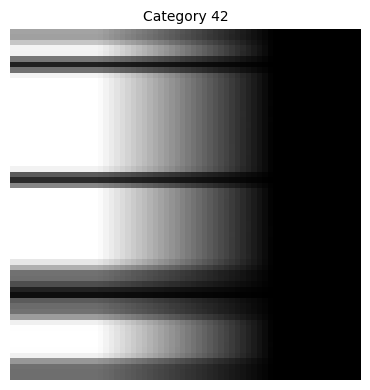

Patch shape: torch.Size([1, 64, 64])


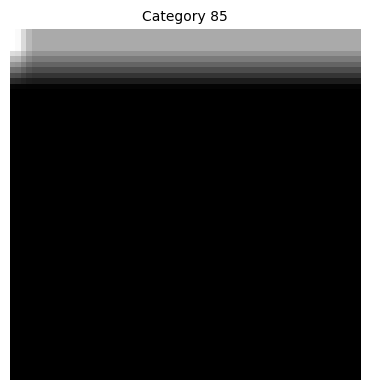

Patch shape: torch.Size([1, 64, 64])


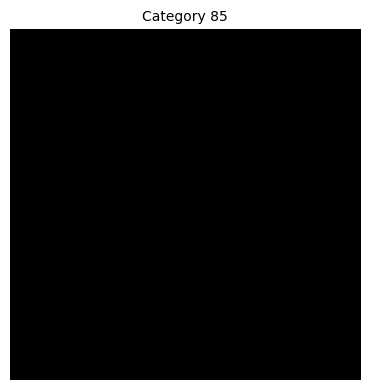

Patch shape: torch.Size([1, 64, 64])


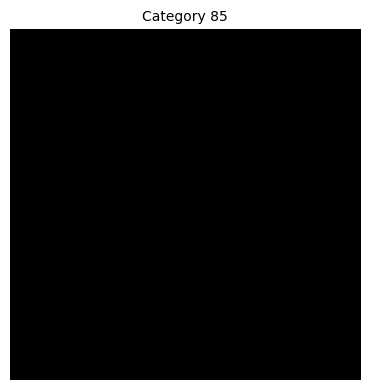

Patch shape: torch.Size([1, 64, 64])


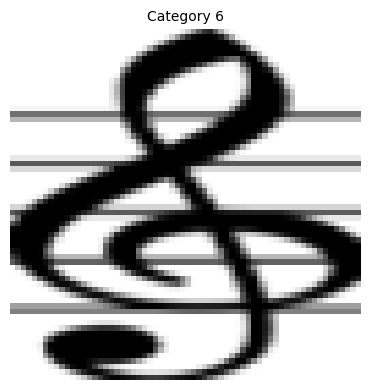

Patch shape: torch.Size([1, 64, 64])


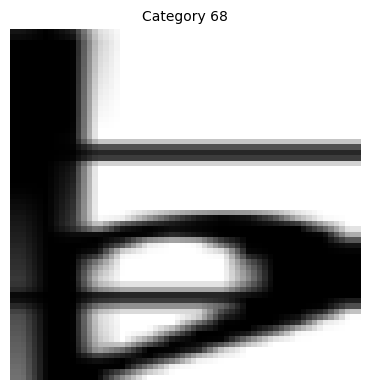

Patch shape: torch.Size([1, 64, 64])


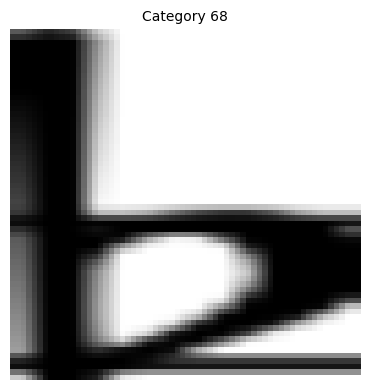

Patch shape: torch.Size([1, 64, 64])


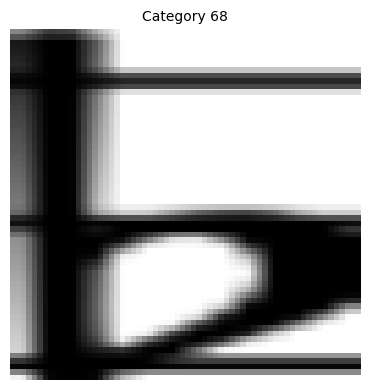

Patch shape: torch.Size([1, 64, 64])


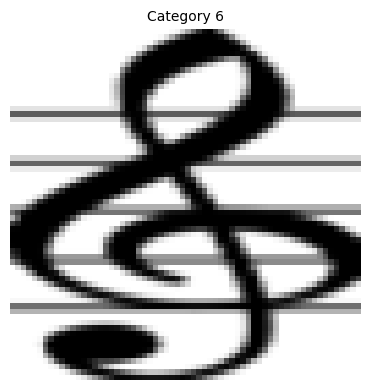

Patch shape: torch.Size([1, 64, 64])


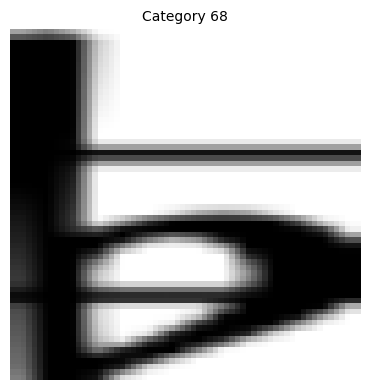

Patch shape: torch.Size([1, 64, 64])


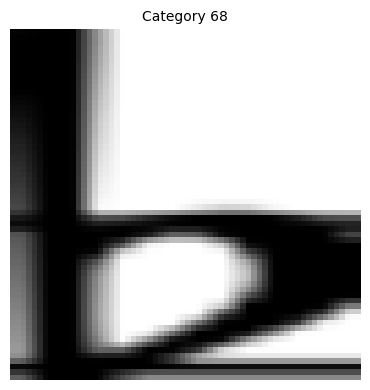

Patch shape: torch.Size([1, 64, 64])


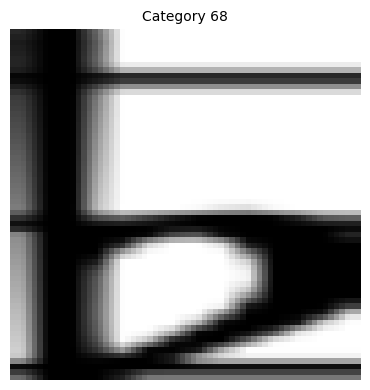

Patch shape: torch.Size([1, 64, 64])


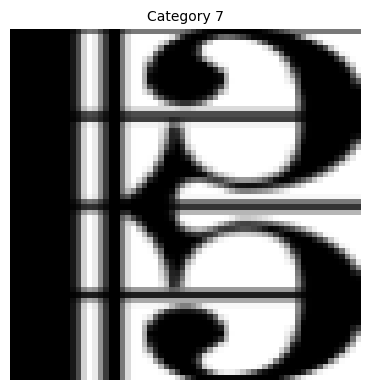

Patch shape: torch.Size([1, 64, 64])


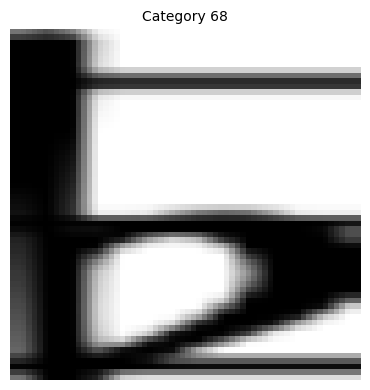

Patch shape: torch.Size([1, 64, 64])


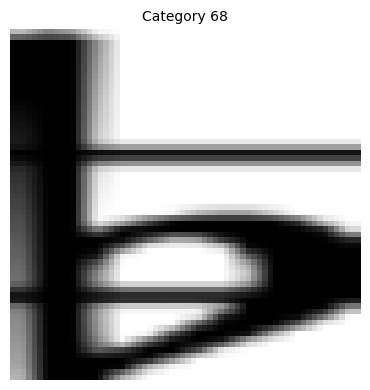

Patch shape: torch.Size([1, 64, 64])


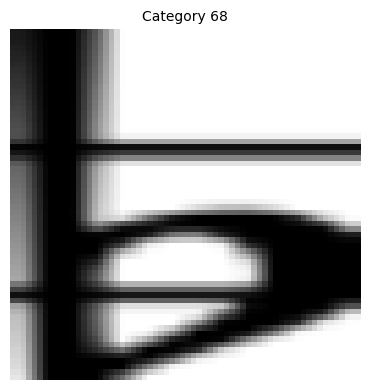

Patch shape: torch.Size([1, 64, 64])


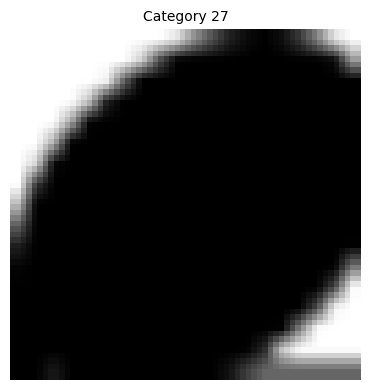

Patch shape: torch.Size([1, 64, 64])


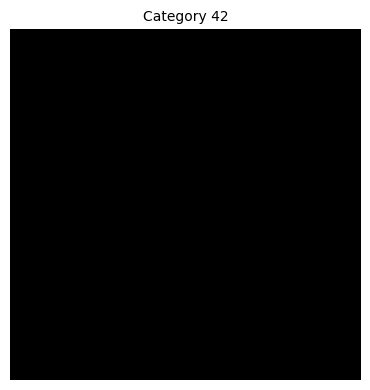

Patch shape: torch.Size([1, 64, 64])


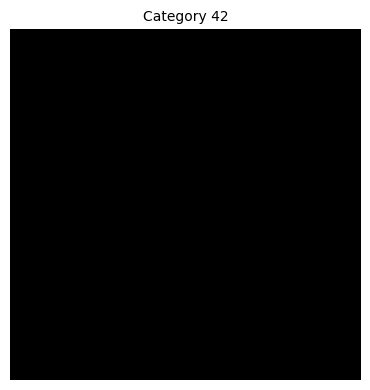

Patch shape: torch.Size([1, 64, 64])


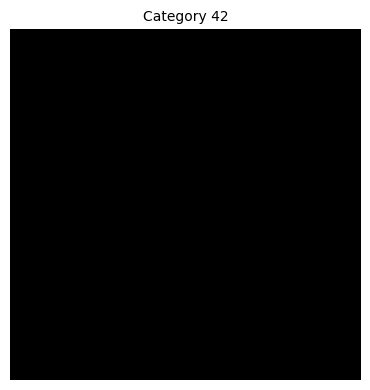

Patch shape: torch.Size([1, 64, 64])


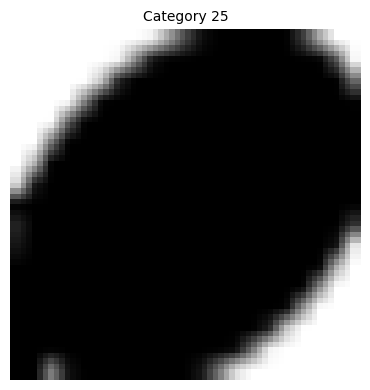

Patch shape: torch.Size([1, 64, 64])


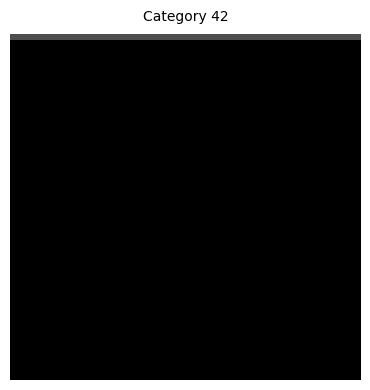

Patch shape: torch.Size([1, 64, 64])


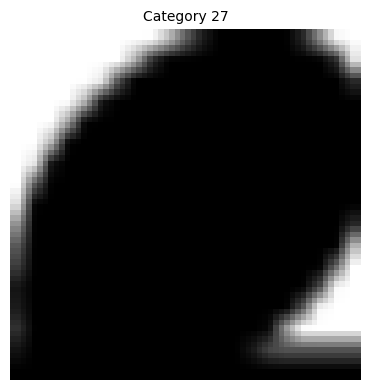

Patch shape: torch.Size([1, 64, 64])


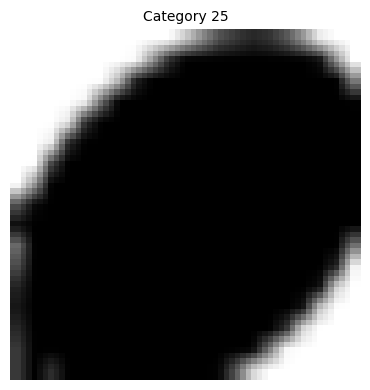

Patch shape: torch.Size([1, 64, 64])


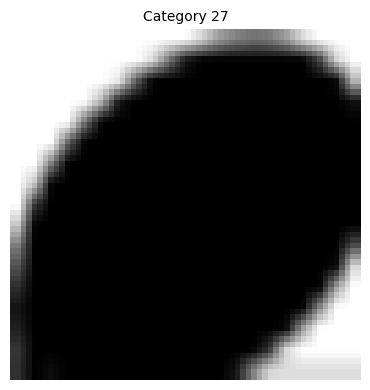

Patch shape: torch.Size([1, 64, 64])


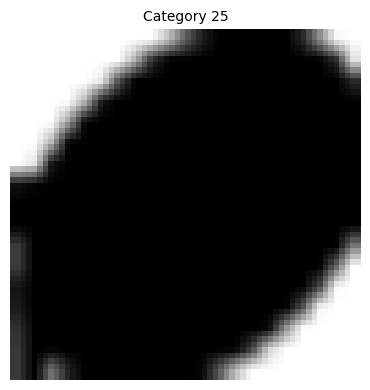

Patch shape: torch.Size([1, 64, 64])


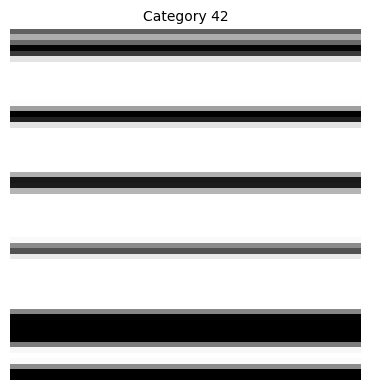

Patch shape: torch.Size([1, 64, 64])


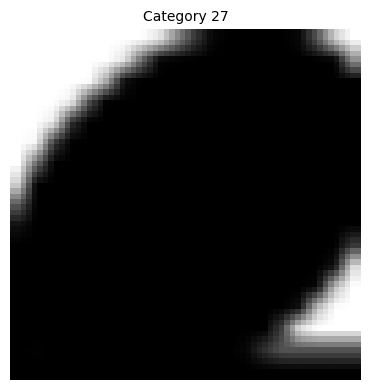

Patch shape: torch.Size([1, 64, 64])


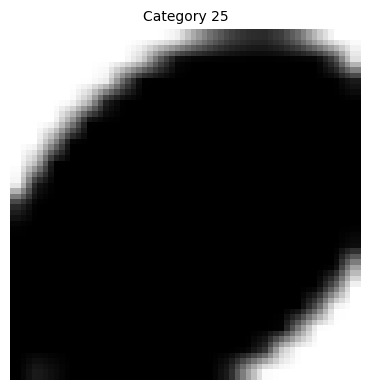

Patch shape: torch.Size([1, 64, 64])


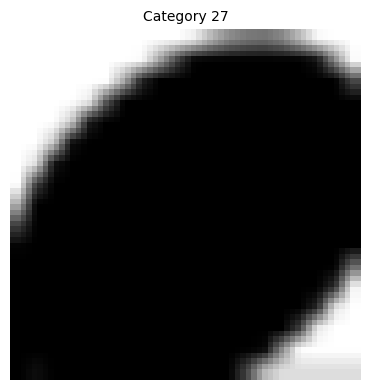

Patch shape: torch.Size([1, 64, 64])


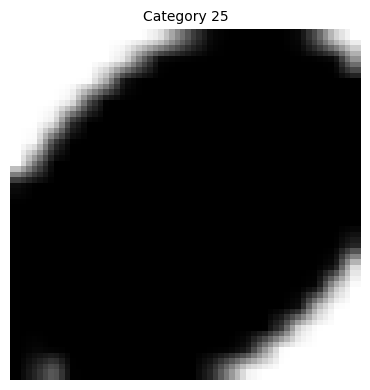

Patch shape: torch.Size([1, 64, 64])


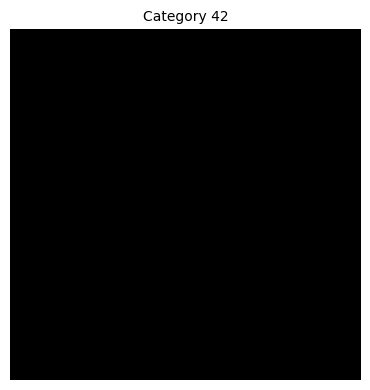

torch.Size([32, 1, 64, 64])
[tensor([42, 42, 42, 25, 27, 42, 42, 42, 42, 25, 27, 27, 42, 42, 42, 42, 27, 25,
        27, 42, 42, 25, 27, 25, 25, 42, 42, 25, 27, 27, 42, 42]), tensor([161, 161, 161, 157, 157, 161, 161, 161, 161, 157, 157, 157, 161, 161,
        161, 161, 157, 157, 157, 161, 161, 157, 157, 157, 157, 161, 161, 157,
        157, 157, 161, 161])]
Patch shape: torch.Size([1, 64, 64])


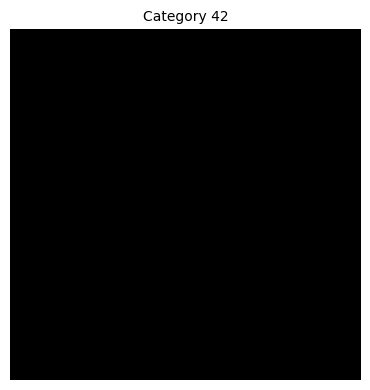

Patch shape: torch.Size([1, 64, 64])


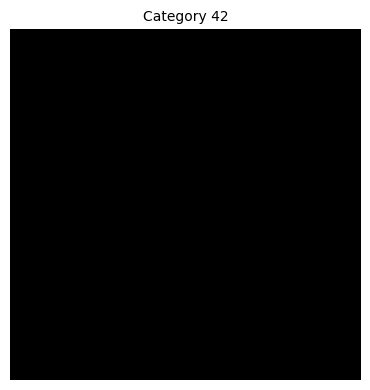

Patch shape: torch.Size([1, 64, 64])


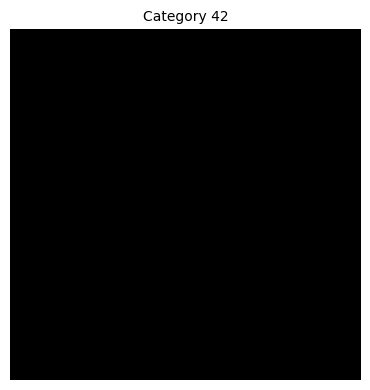

Patch shape: torch.Size([1, 64, 64])


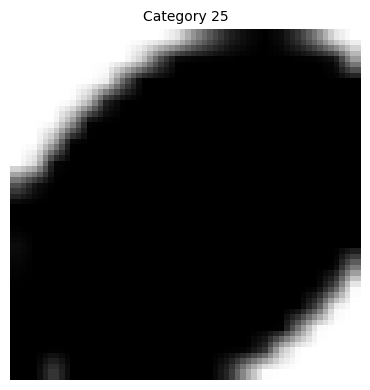

Patch shape: torch.Size([1, 64, 64])


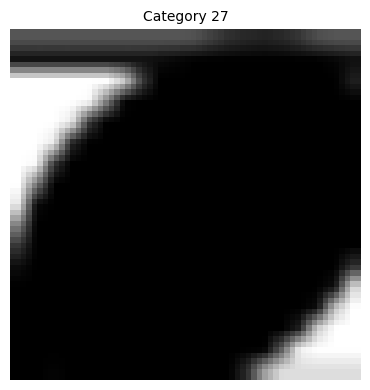

Patch shape: torch.Size([1, 64, 64])


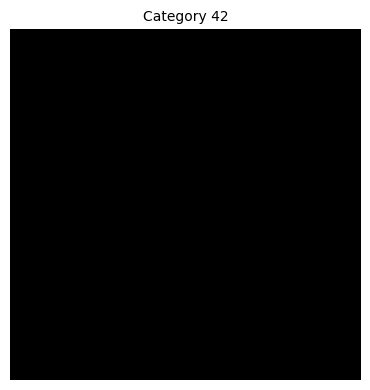

Patch shape: torch.Size([1, 64, 64])


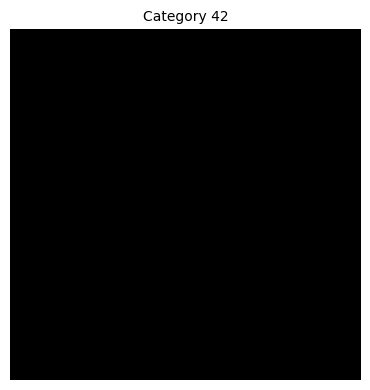

Patch shape: torch.Size([1, 64, 64])


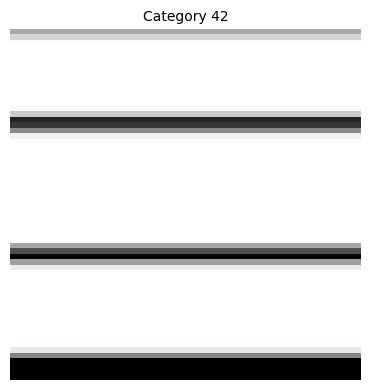

Patch shape: torch.Size([1, 64, 64])


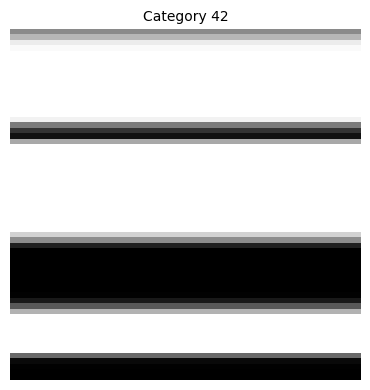

Patch shape: torch.Size([1, 64, 64])


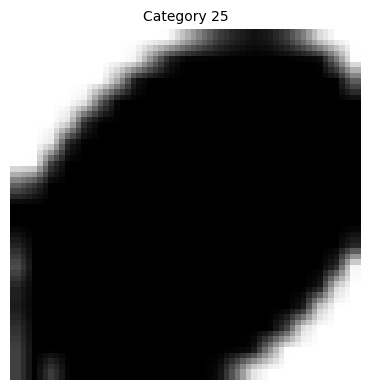

Patch shape: torch.Size([1, 64, 64])


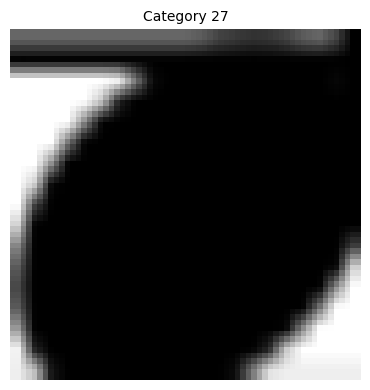

Patch shape: torch.Size([1, 64, 64])


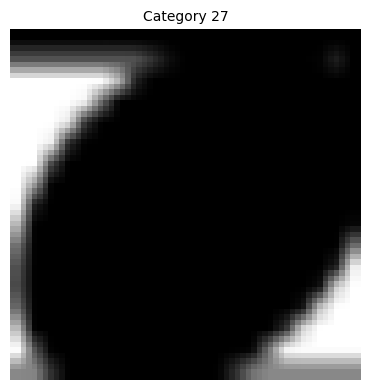

Patch shape: torch.Size([1, 64, 64])


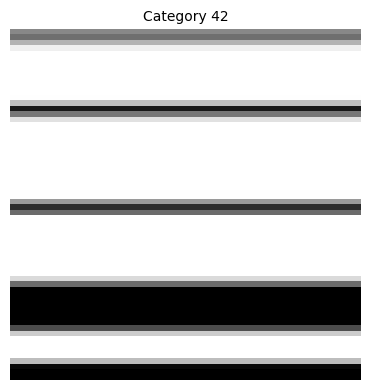

Patch shape: torch.Size([1, 64, 64])


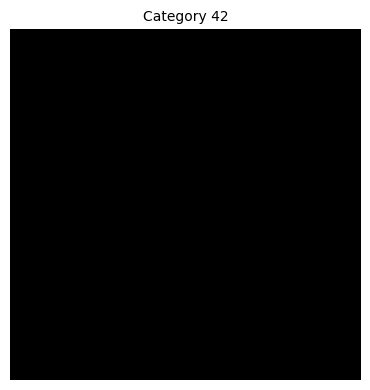

Patch shape: torch.Size([1, 64, 64])


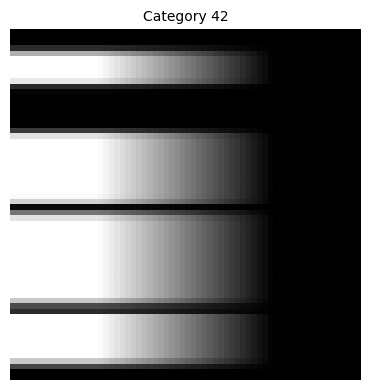

Patch shape: torch.Size([1, 64, 64])


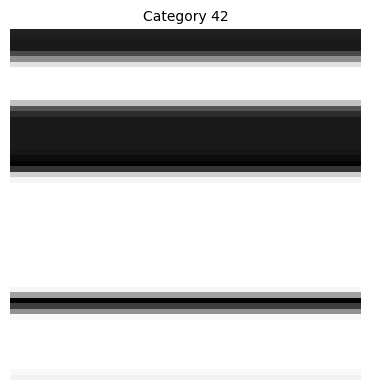

Patch shape: torch.Size([1, 64, 64])


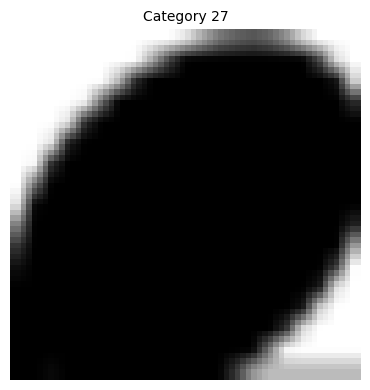

Patch shape: torch.Size([1, 64, 64])


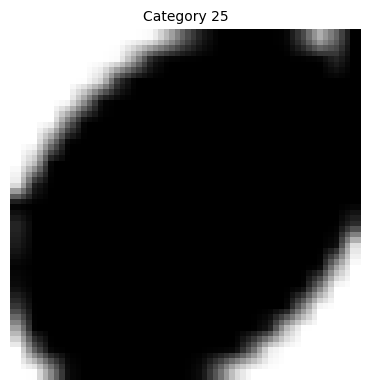

Patch shape: torch.Size([1, 64, 64])


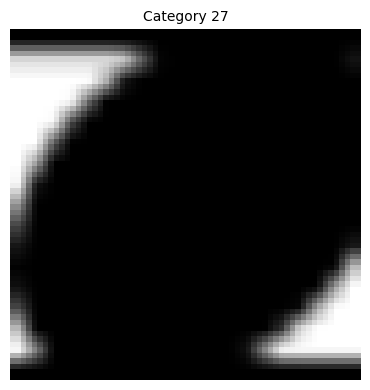

Patch shape: torch.Size([1, 64, 64])


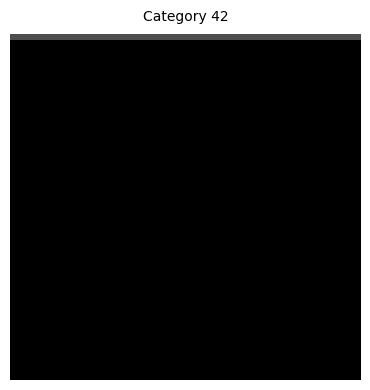

Patch shape: torch.Size([1, 64, 64])


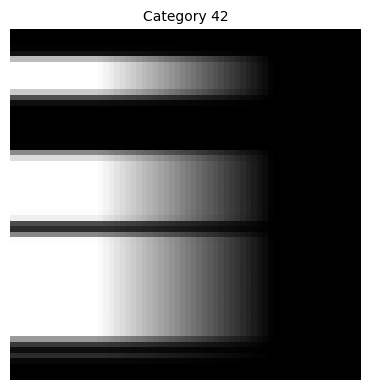

Patch shape: torch.Size([1, 64, 64])


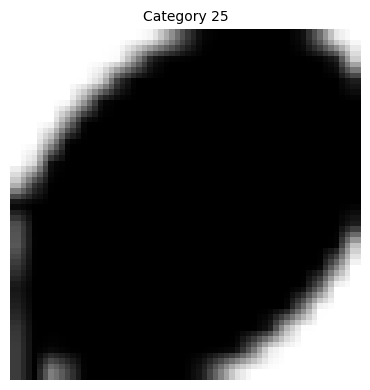

Patch shape: torch.Size([1, 64, 64])


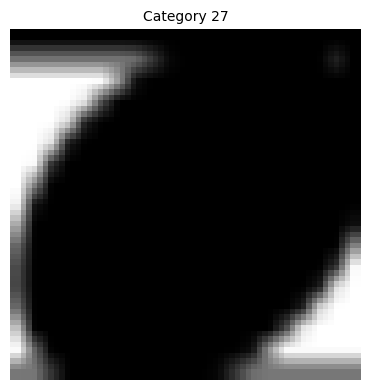

Patch shape: torch.Size([1, 64, 64])


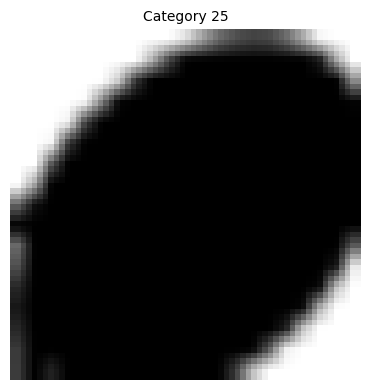

Patch shape: torch.Size([1, 64, 64])


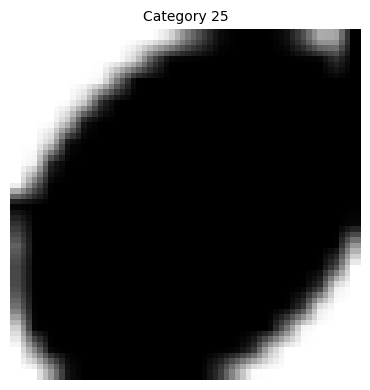

Patch shape: torch.Size([1, 64, 64])


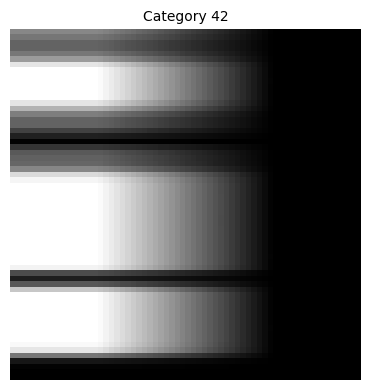

Patch shape: torch.Size([1, 64, 64])


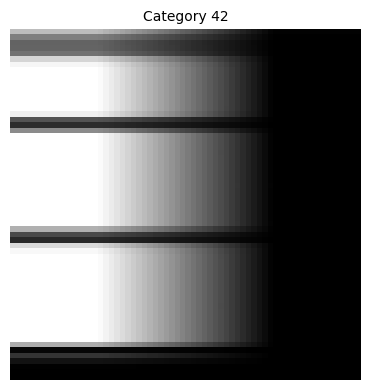

Patch shape: torch.Size([1, 64, 64])


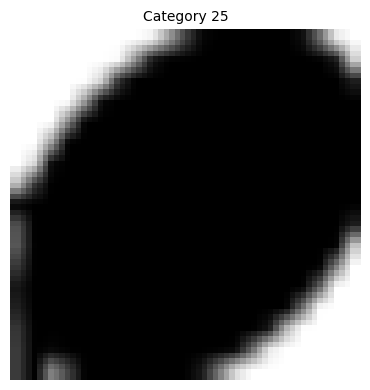

Patch shape: torch.Size([1, 64, 64])


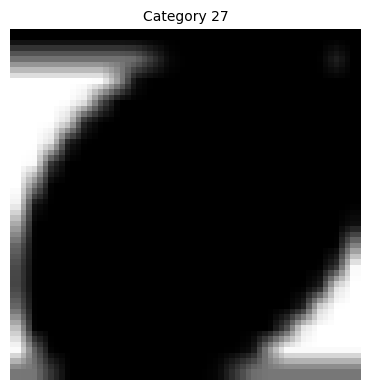

Patch shape: torch.Size([1, 64, 64])


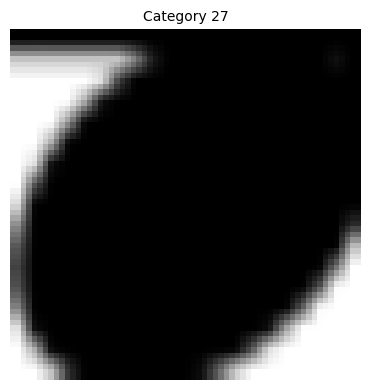

Patch shape: torch.Size([1, 64, 64])


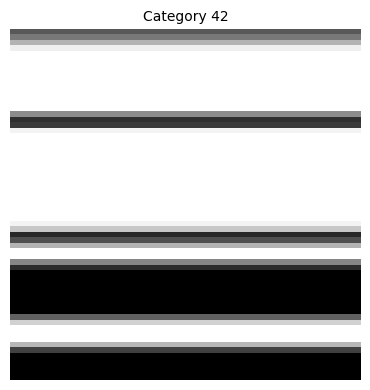

Patch shape: torch.Size([1, 64, 64])


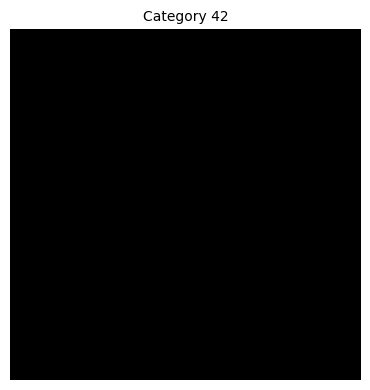

torch.Size([32, 1, 64, 64])
[tensor([27, 25, 27, 25, 42, 42, 60, 42, 25, 27, 25, 25, 42, 42, 42, 42, 42, 42,
        42, 27, 25, 27, 42, 60, 42, 25, 42, 42, 25, 27, 25, 42]), tensor([157, 157, 157, 157, 161, 161, 171, 161, 157, 157, 157, 157, 161, 161,
        161, 161, 161, 161, 161, 157, 157, 157, 161, 171, 161, 157, 161, 161,
        157, 157, 157, 161])]
Patch shape: torch.Size([1, 64, 64])


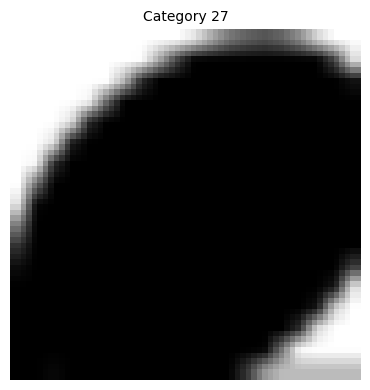

Patch shape: torch.Size([1, 64, 64])


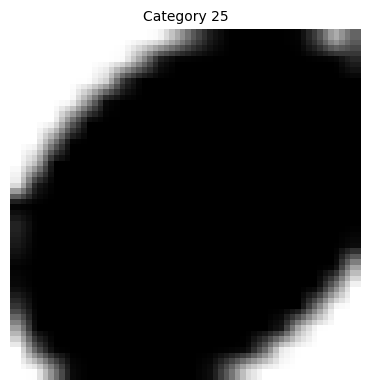

Patch shape: torch.Size([1, 64, 64])


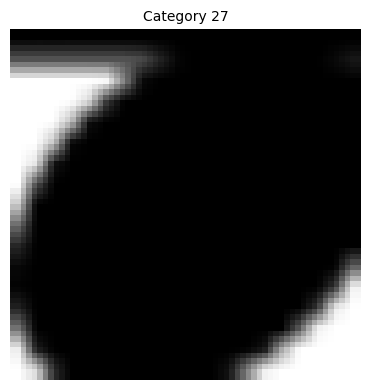

Patch shape: torch.Size([1, 64, 64])


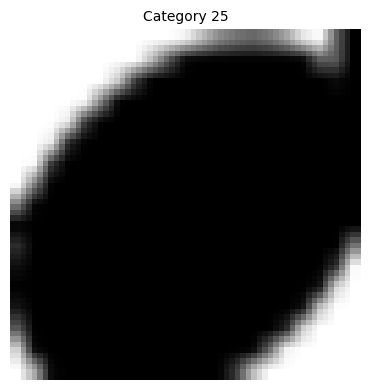

Patch shape: torch.Size([1, 64, 64])


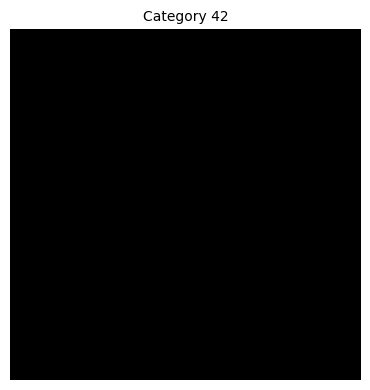

Patch shape: torch.Size([1, 64, 64])


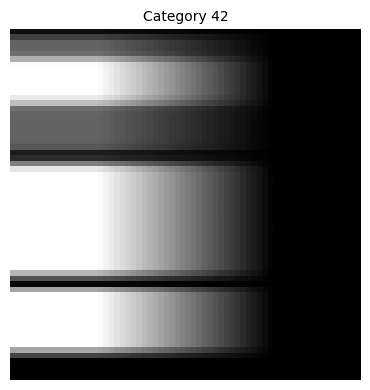

Patch shape: torch.Size([1, 64, 64])


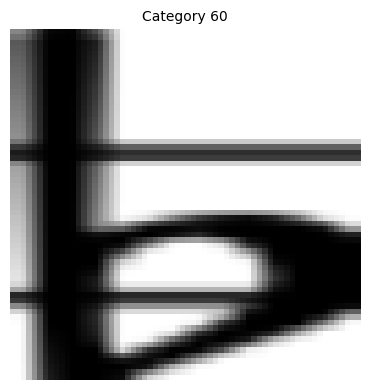

Patch shape: torch.Size([1, 64, 64])


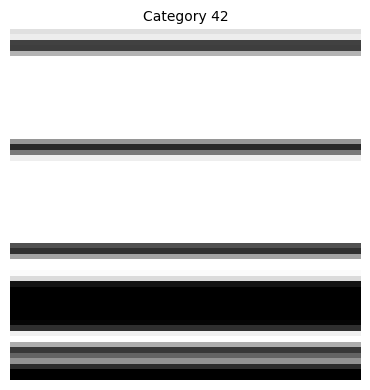

Patch shape: torch.Size([1, 64, 64])


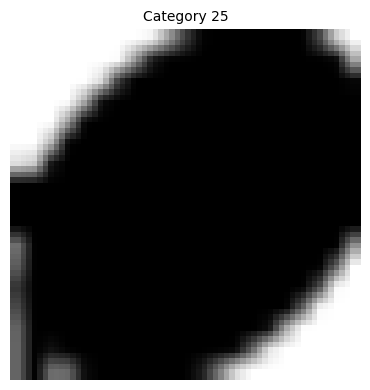

Patch shape: torch.Size([1, 64, 64])


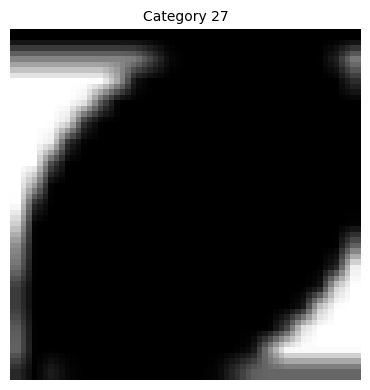

Patch shape: torch.Size([1, 64, 64])


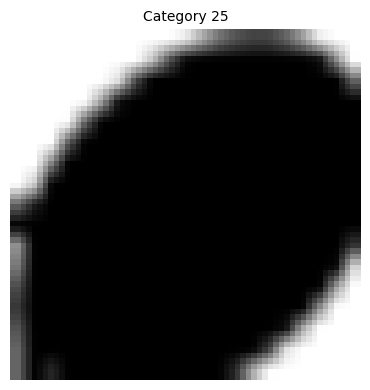

Patch shape: torch.Size([1, 64, 64])


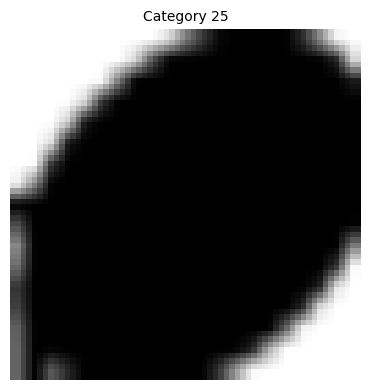

Patch shape: torch.Size([1, 64, 64])


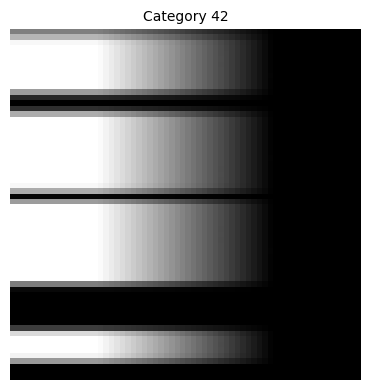

Patch shape: torch.Size([1, 64, 64])


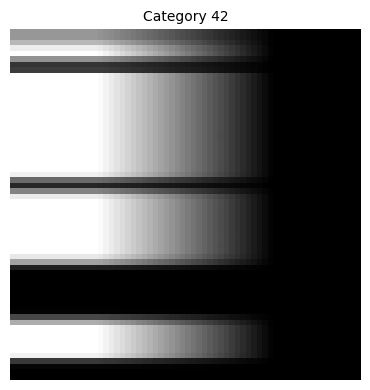

Patch shape: torch.Size([1, 64, 64])


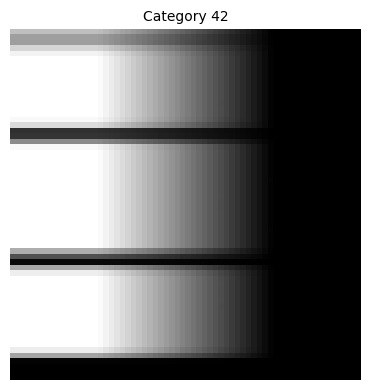

Patch shape: torch.Size([1, 64, 64])


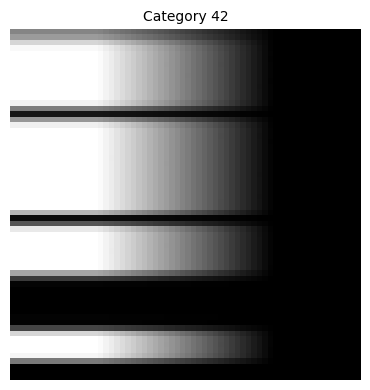

Patch shape: torch.Size([1, 64, 64])


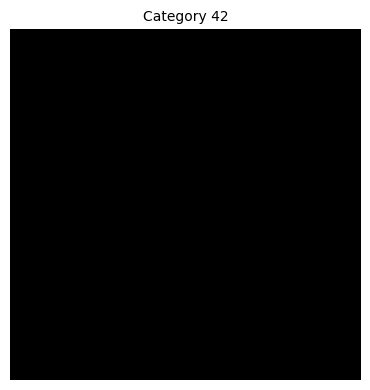

Patch shape: torch.Size([1, 64, 64])


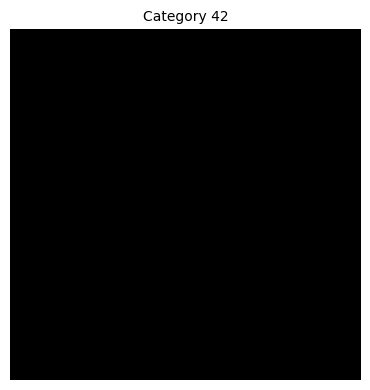

Patch shape: torch.Size([1, 64, 64])


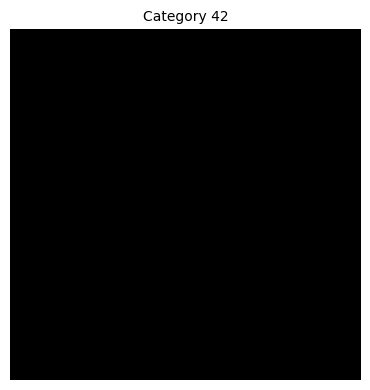

Patch shape: torch.Size([1, 64, 64])


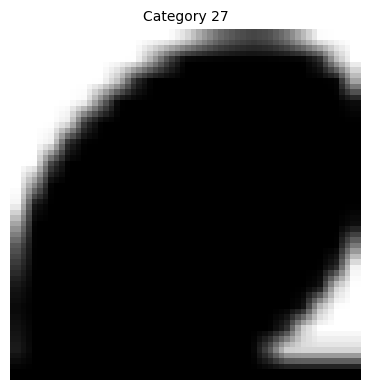

Patch shape: torch.Size([1, 64, 64])


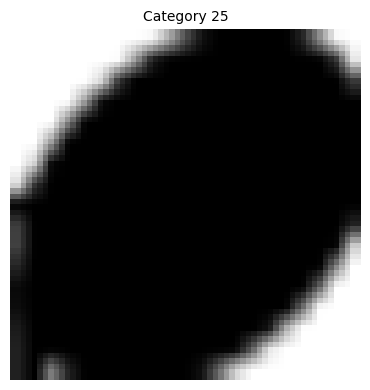

Patch shape: torch.Size([1, 64, 64])


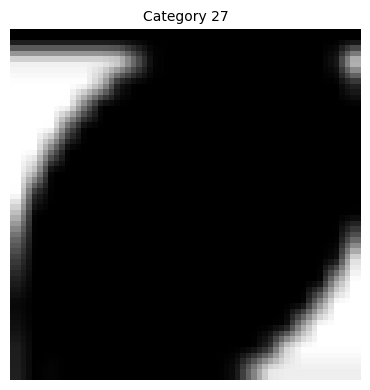

Patch shape: torch.Size([1, 64, 64])


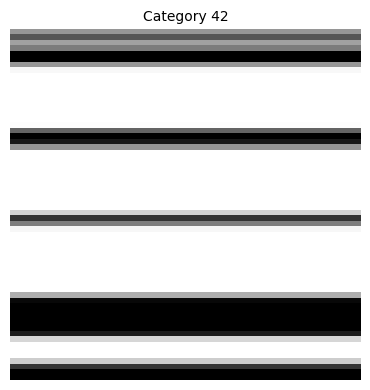

Patch shape: torch.Size([1, 64, 64])


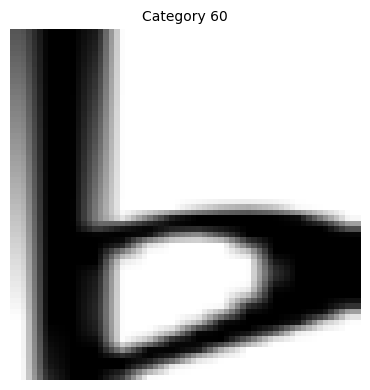

Patch shape: torch.Size([1, 64, 64])


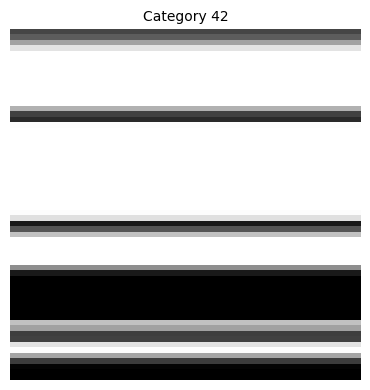

Patch shape: torch.Size([1, 64, 64])


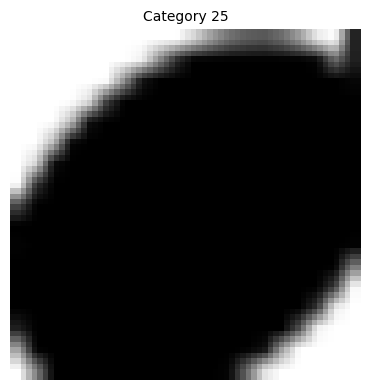

Patch shape: torch.Size([1, 64, 64])


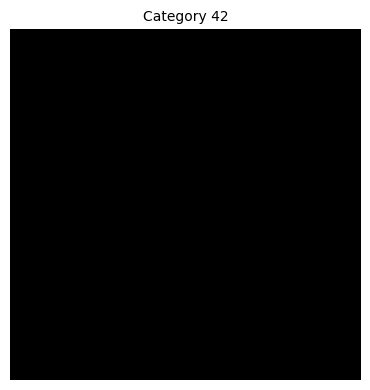

Patch shape: torch.Size([1, 64, 64])


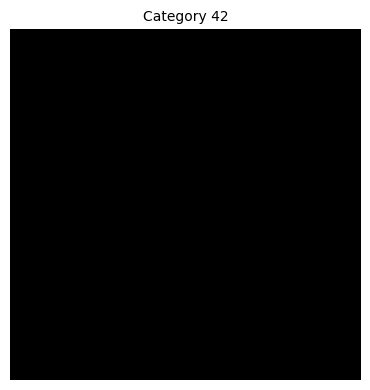

Patch shape: torch.Size([1, 64, 64])


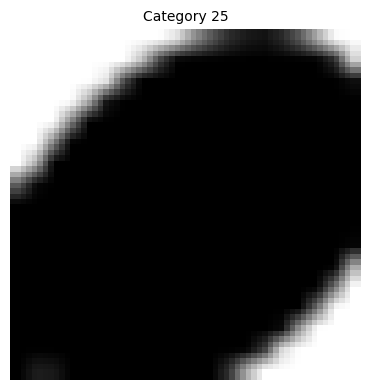

Patch shape: torch.Size([1, 64, 64])


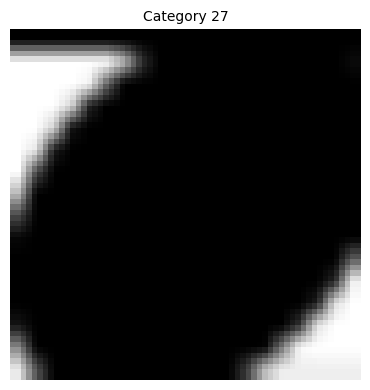

Patch shape: torch.Size([1, 64, 64])


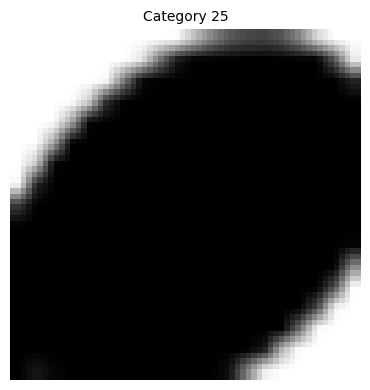

Patch shape: torch.Size([1, 64, 64])


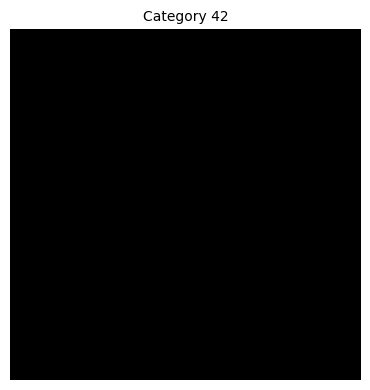

staff line
staff line
staff line
staff line
torch.Size([32, 1, 64, 64])
[tensor([42, 42, 27, 42, 27, 25,  2,  2, 42, 42, 48, 42, 27, 27, 27, 48, 27, 25,
        25, 42, 48, 42, 25, 42, 25, 42, 42, 25, 27, 42, 25, 42]), tensor([161, 161, 157, 161, 157, 157, 138, 138, 161, 161, 163, 161, 157, 157,
        157, 163, 157, 157, 157, 161, 163, 161, 157, 161, 157, 161, 161, 157,
        157, 161, 157, 161])]
Patch shape: torch.Size([1, 64, 64])


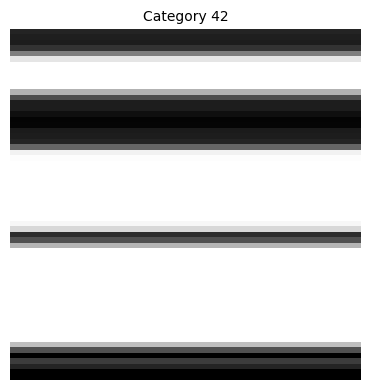

Patch shape: torch.Size([1, 64, 64])


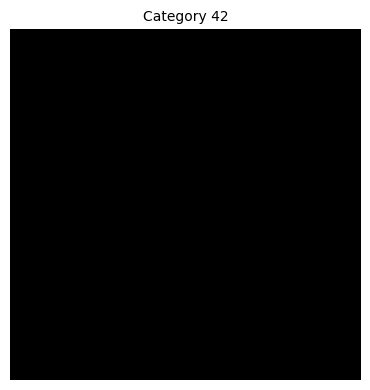

Patch shape: torch.Size([1, 64, 64])


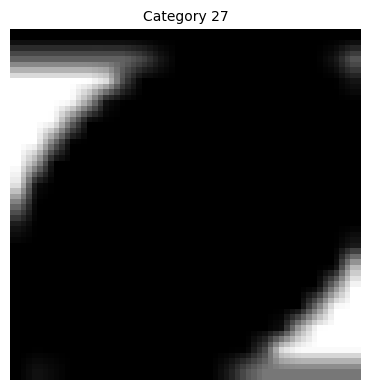

Patch shape: torch.Size([1, 64, 64])


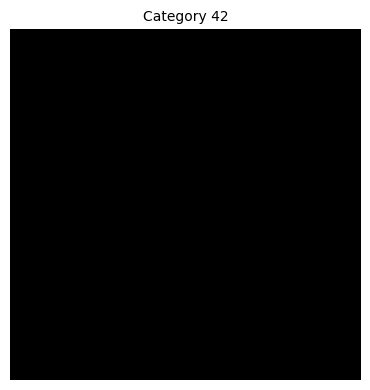

Patch shape: torch.Size([1, 64, 64])


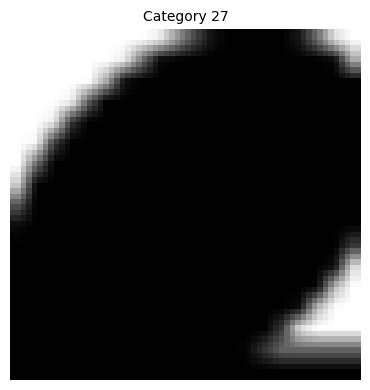

Patch shape: torch.Size([1, 64, 64])


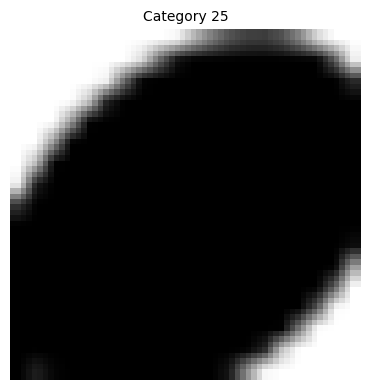

Patch shape: torch.Size([1, 64, 64])


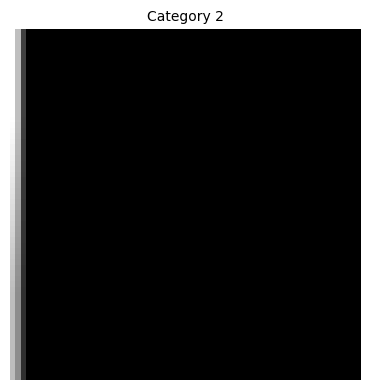

Patch shape: torch.Size([1, 64, 64])


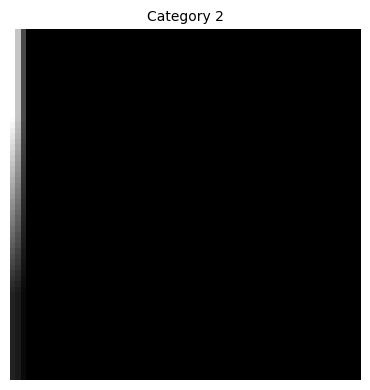

Patch shape: torch.Size([1, 64, 64])


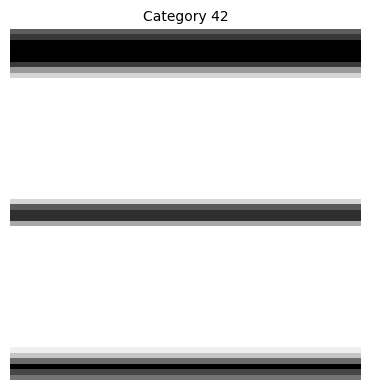

Patch shape: torch.Size([1, 64, 64])


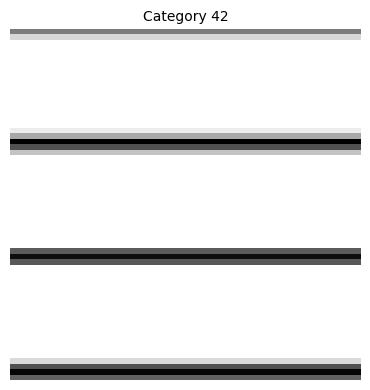

Patch shape: torch.Size([1, 64, 64])


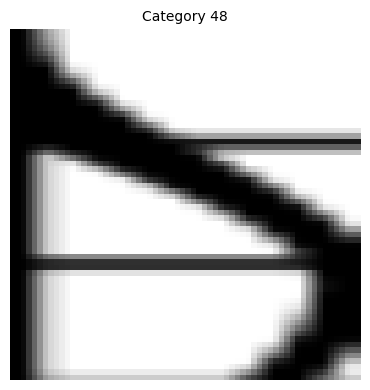

Patch shape: torch.Size([1, 64, 64])


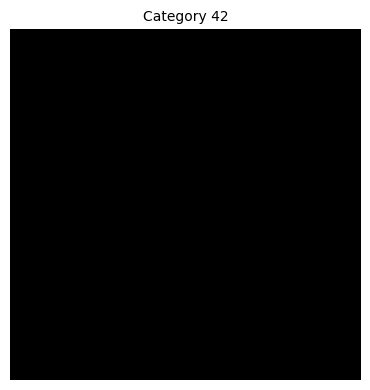

Patch shape: torch.Size([1, 64, 64])


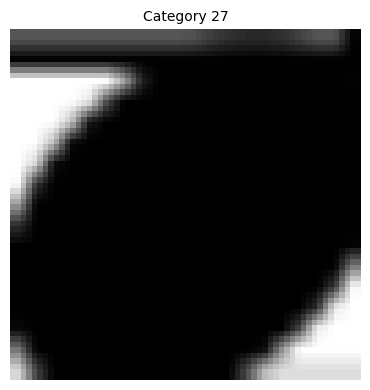

Patch shape: torch.Size([1, 64, 64])


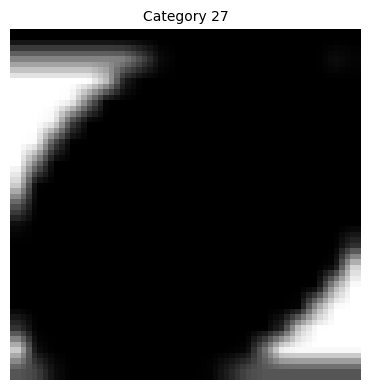

Patch shape: torch.Size([1, 64, 64])


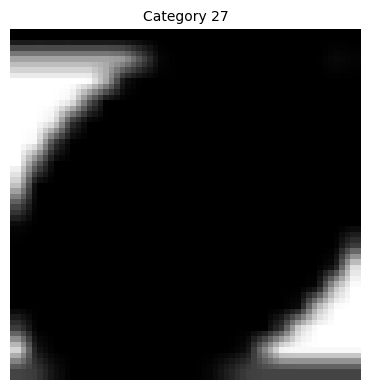

Patch shape: torch.Size([1, 64, 64])


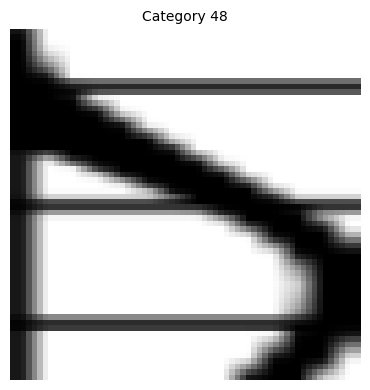

Patch shape: torch.Size([1, 64, 64])


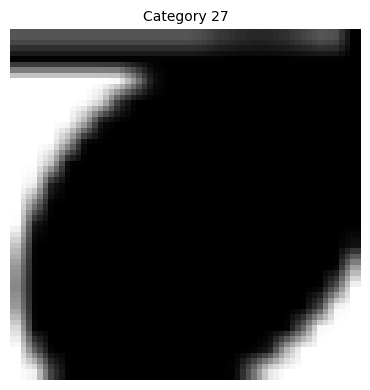

Patch shape: torch.Size([1, 64, 64])


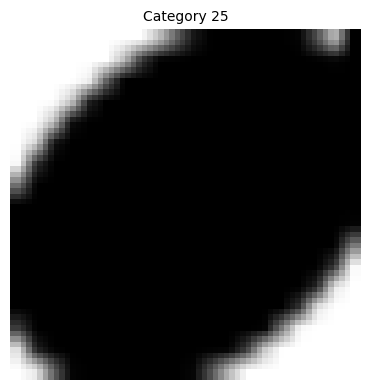

Patch shape: torch.Size([1, 64, 64])


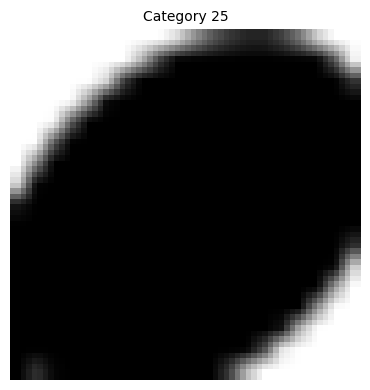

Patch shape: torch.Size([1, 64, 64])


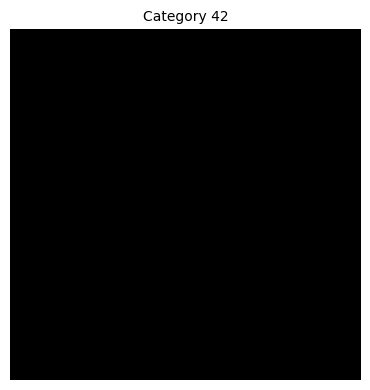

Patch shape: torch.Size([1, 64, 64])


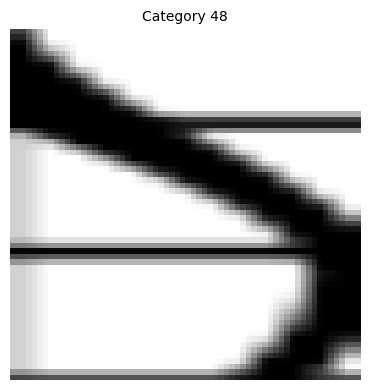

Patch shape: torch.Size([1, 64, 64])


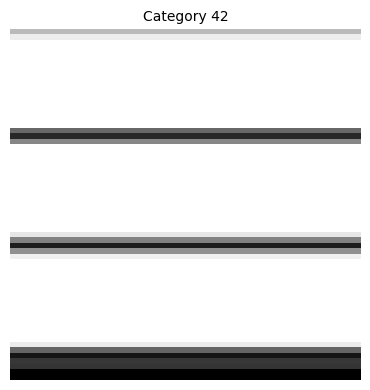

Patch shape: torch.Size([1, 64, 64])


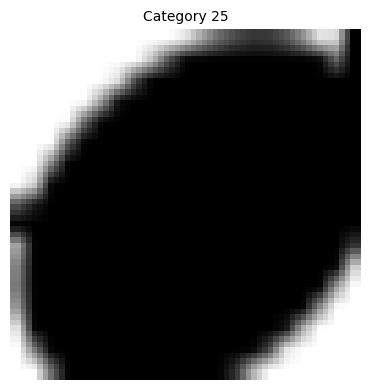

Patch shape: torch.Size([1, 64, 64])


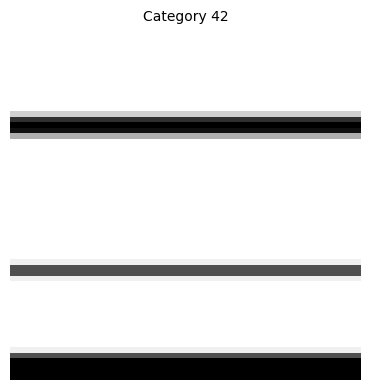

Patch shape: torch.Size([1, 64, 64])


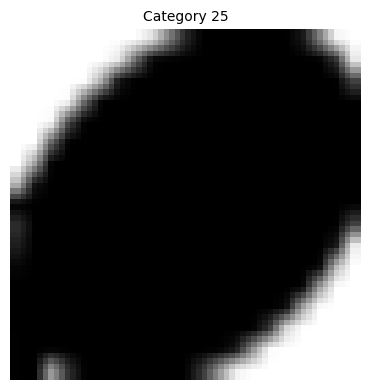

Patch shape: torch.Size([1, 64, 64])


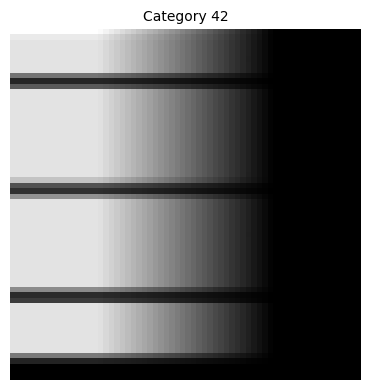

Patch shape: torch.Size([1, 64, 64])


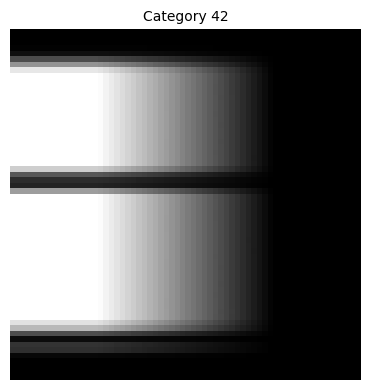

Patch shape: torch.Size([1, 64, 64])


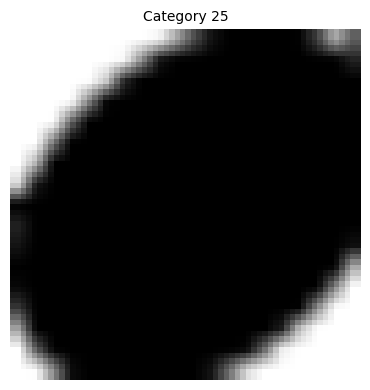

Patch shape: torch.Size([1, 64, 64])


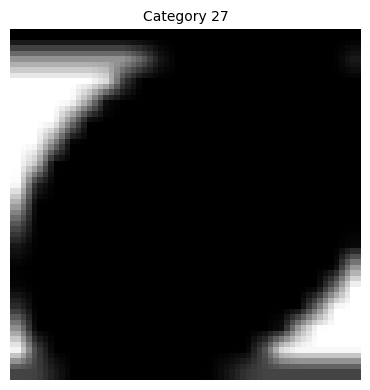

Patch shape: torch.Size([1, 64, 64])


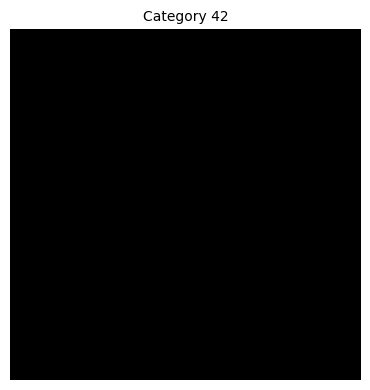

Patch shape: torch.Size([1, 64, 64])


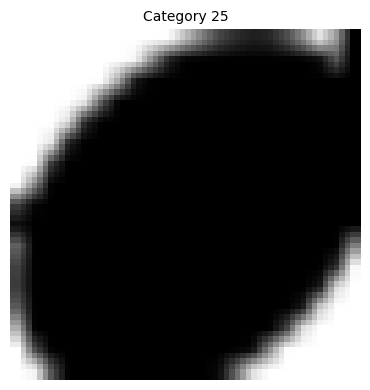

Patch shape: torch.Size([1, 64, 64])


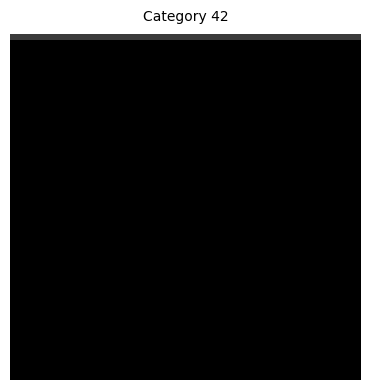

torch.Size([32, 1, 64, 64])
[tensor([ 42, 122,  60,  42,  25,  27,  42,  25,  42,  42,  25,  27,  54,  42,
         42,  25,  88,  25,  42,  25, 122, 122,  85,  85, 122, 122,  85,  85,
        122, 122, 122,  60]), tensor([161, 201, 171, 161, 157, 157, 161, 157, 161, 161, 157, 157, 167, 161,
        161, 157, 186, 157, 161, 157, 201, 201, 183, 183, 201, 201, 183, 183,
        201, 201, 201, 171])]
Patch shape: torch.Size([1, 64, 64])


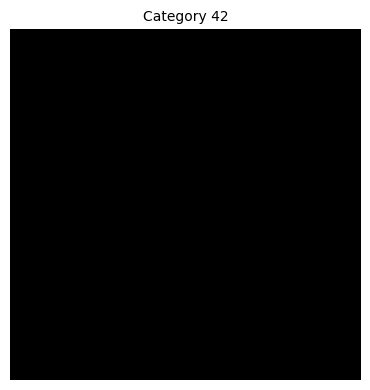

Patch shape: torch.Size([1, 64, 64])


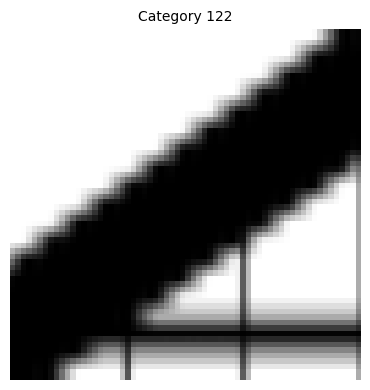

Patch shape: torch.Size([1, 64, 64])


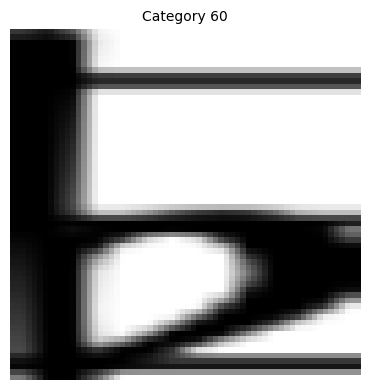

Patch shape: torch.Size([1, 64, 64])


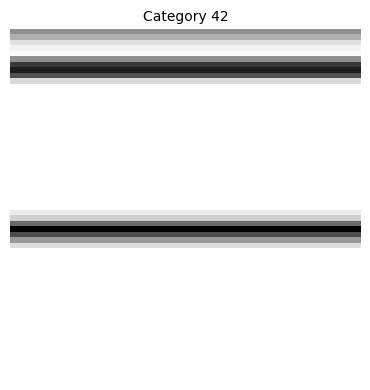

Patch shape: torch.Size([1, 64, 64])


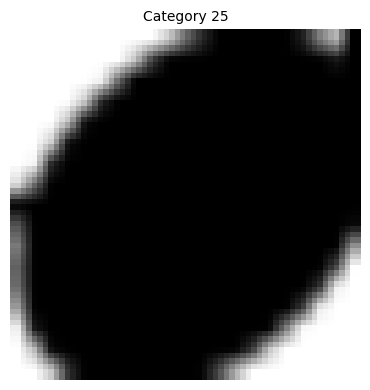

Patch shape: torch.Size([1, 64, 64])


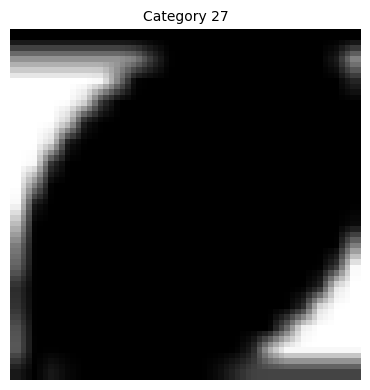

Patch shape: torch.Size([1, 64, 64])


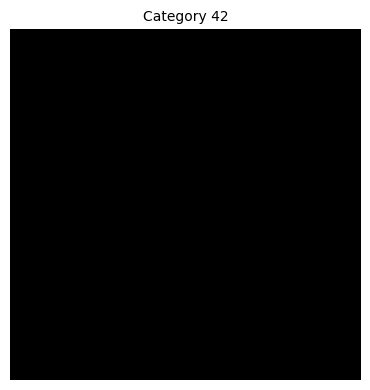

Patch shape: torch.Size([1, 64, 64])


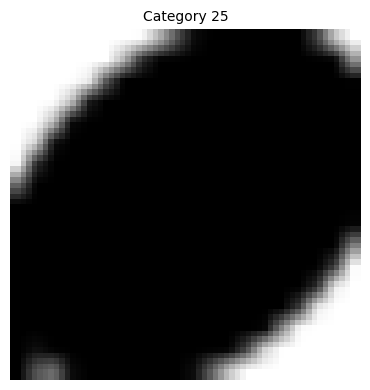

Patch shape: torch.Size([1, 64, 64])


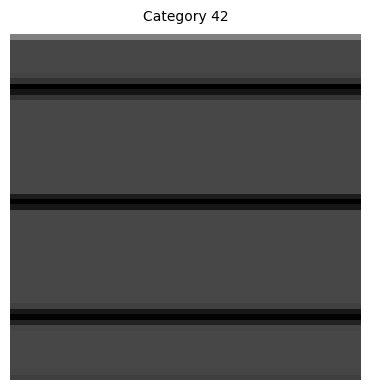

Patch shape: torch.Size([1, 64, 64])


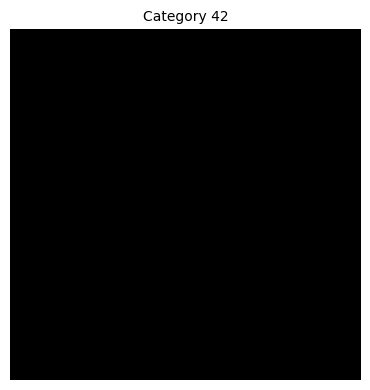

Patch shape: torch.Size([1, 64, 64])


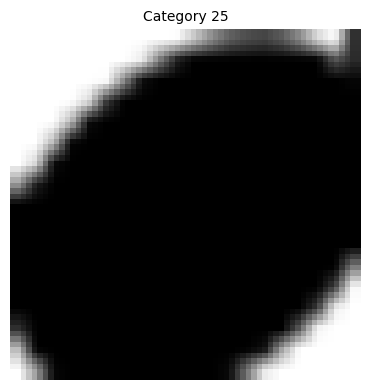

Patch shape: torch.Size([1, 64, 64])


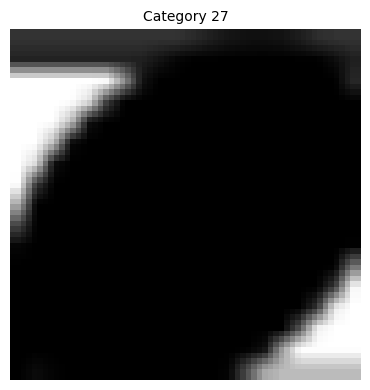

Patch shape: torch.Size([1, 64, 64])


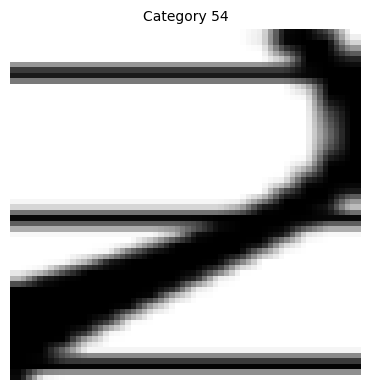

Patch shape: torch.Size([1, 64, 64])


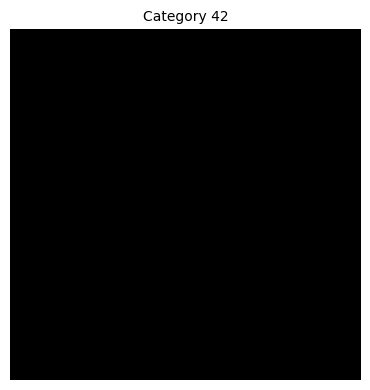

Patch shape: torch.Size([1, 64, 64])


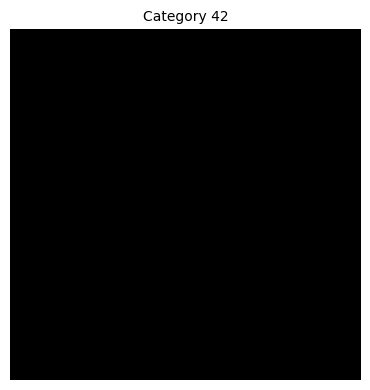

Patch shape: torch.Size([1, 64, 64])


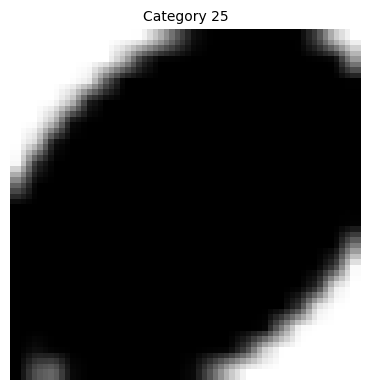

Patch shape: torch.Size([1, 64, 64])


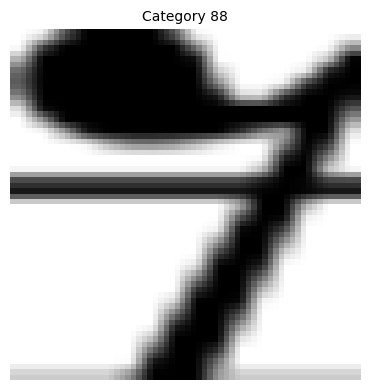

Patch shape: torch.Size([1, 64, 64])


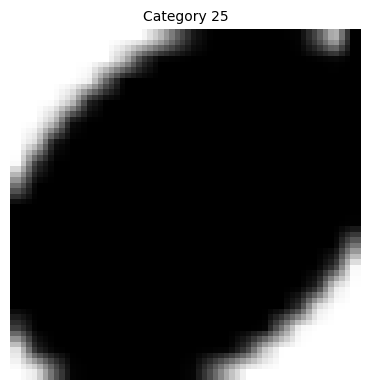

Patch shape: torch.Size([1, 64, 64])


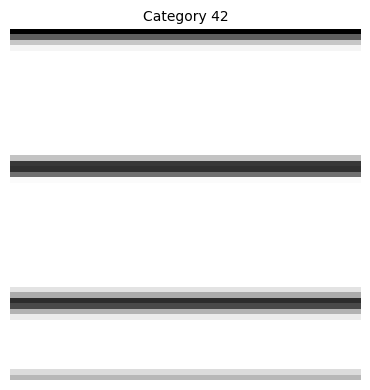

Patch shape: torch.Size([1, 64, 64])


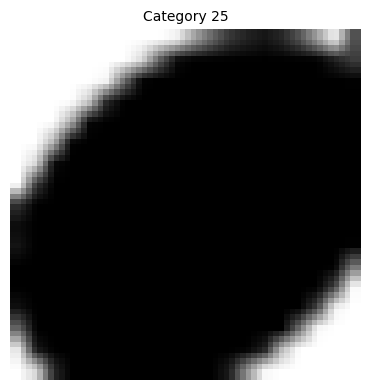

Patch shape: torch.Size([1, 64, 64])


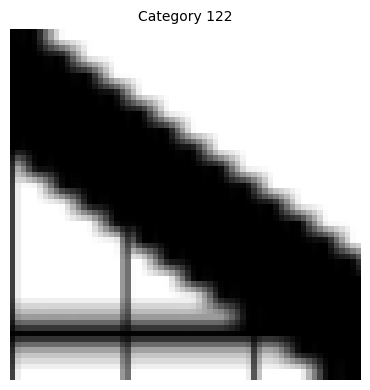

Patch shape: torch.Size([1, 64, 64])


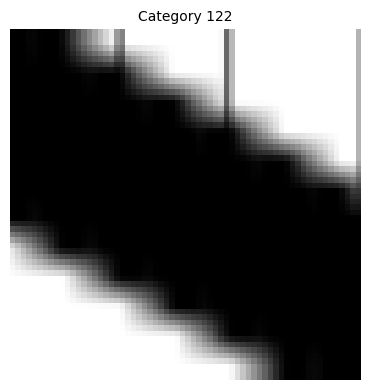

Patch shape: torch.Size([1, 64, 64])


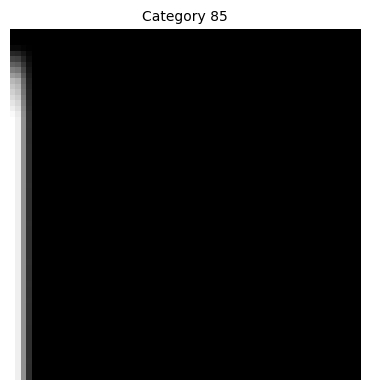

Patch shape: torch.Size([1, 64, 64])


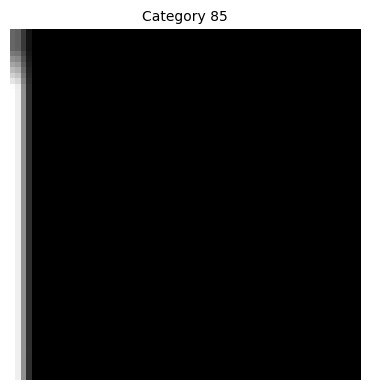

Patch shape: torch.Size([1, 64, 64])


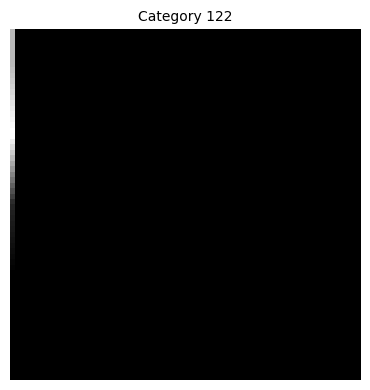

Patch shape: torch.Size([1, 64, 64])


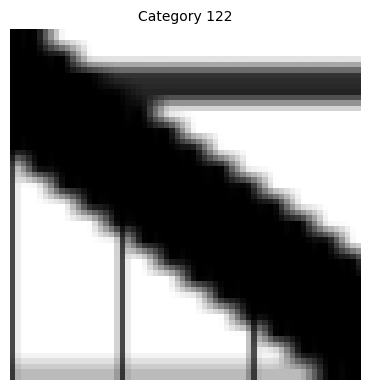

Patch shape: torch.Size([1, 64, 64])


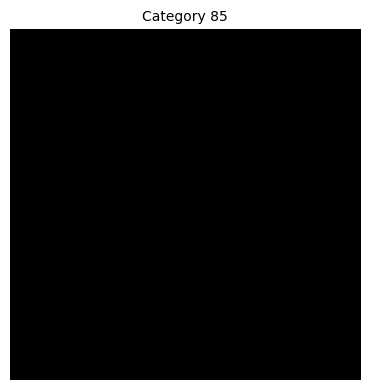

Patch shape: torch.Size([1, 64, 64])


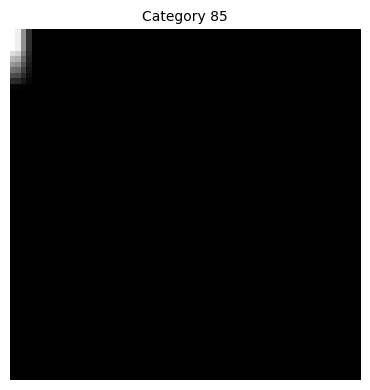

Patch shape: torch.Size([1, 64, 64])


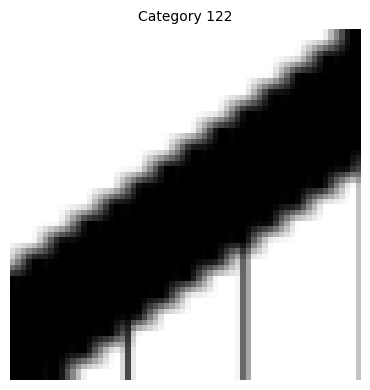

Patch shape: torch.Size([1, 64, 64])


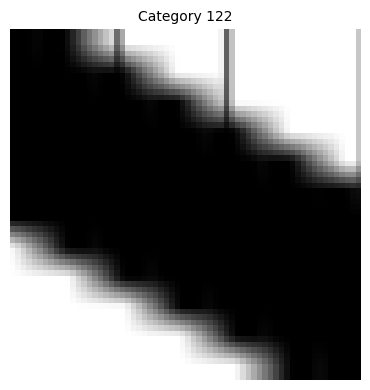

Patch shape: torch.Size([1, 64, 64])


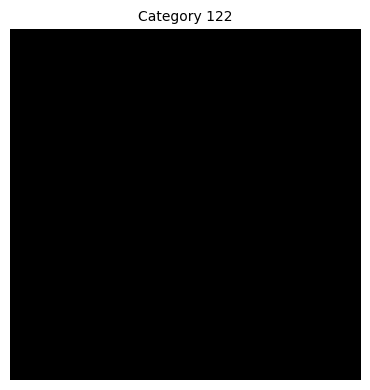

Patch shape: torch.Size([1, 64, 64])


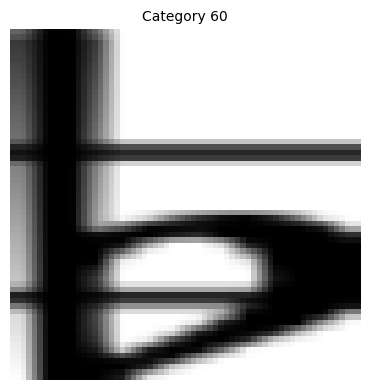

torch.Size([32, 1, 64, 64])
[tensor([25, 42, 42, 27, 88, 42, 27, 42, 27, 42, 42, 42, 25, 42, 25, 48, 42, 42,
        27, 25, 60, 42, 25, 42, 27, 42, 25, 42, 27, 27, 42, 42]), tensor([157, 161, 161, 157, 186, 161, 157, 161, 157, 161, 161, 161, 157, 161,
        157, 163, 161, 161, 157, 157, 171, 161, 157, 161, 157, 161, 157, 161,
        157, 157, 161, 161])]
Patch shape: torch.Size([1, 64, 64])


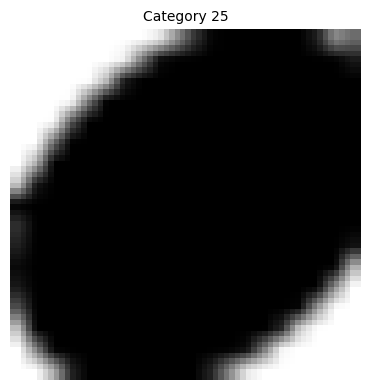

Patch shape: torch.Size([1, 64, 64])


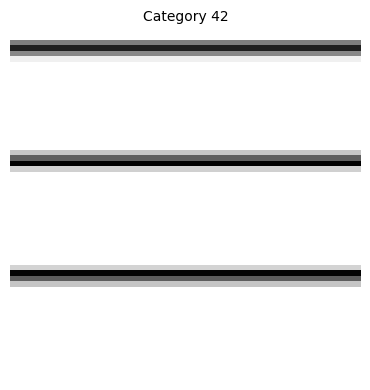

Patch shape: torch.Size([1, 64, 64])


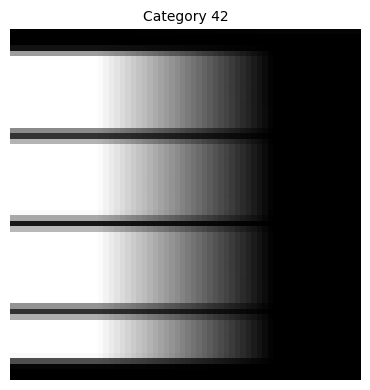

Patch shape: torch.Size([1, 64, 64])


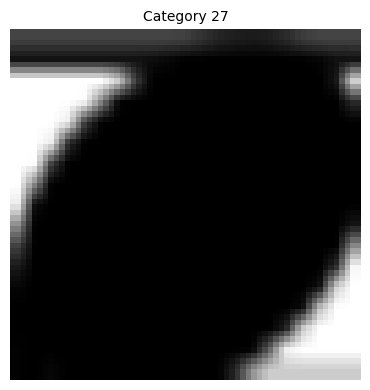

Patch shape: torch.Size([1, 64, 64])


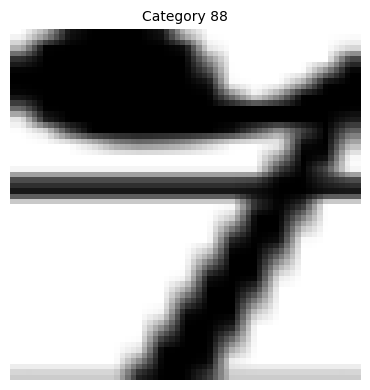

Patch shape: torch.Size([1, 64, 64])


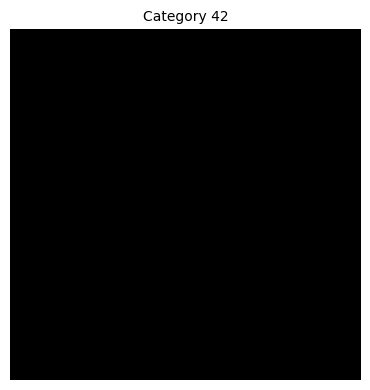

Patch shape: torch.Size([1, 64, 64])


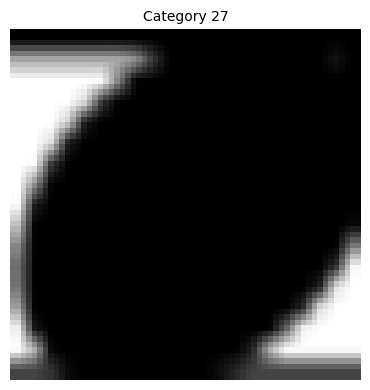

Patch shape: torch.Size([1, 64, 64])


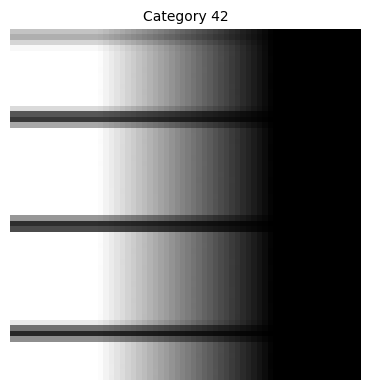

Patch shape: torch.Size([1, 64, 64])


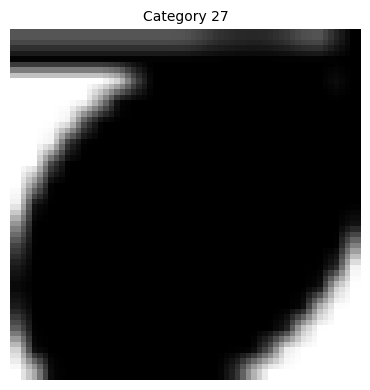

Patch shape: torch.Size([1, 64, 64])


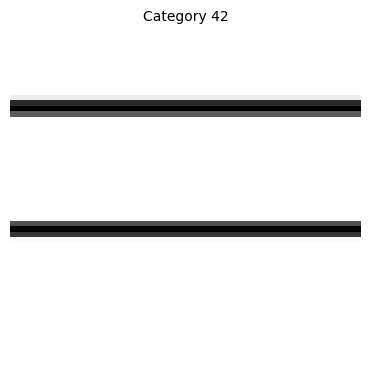

Patch shape: torch.Size([1, 64, 64])


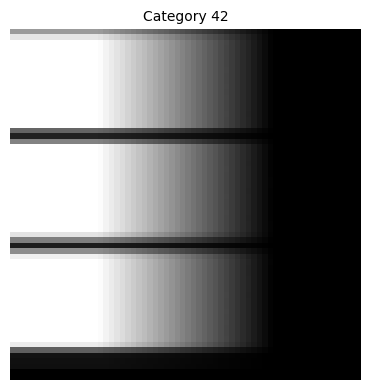

Patch shape: torch.Size([1, 64, 64])


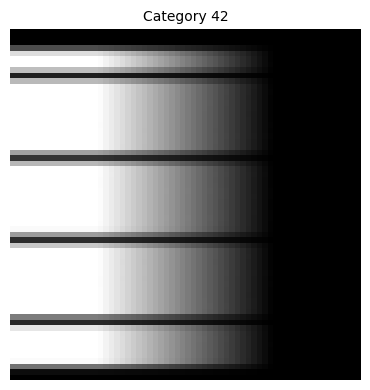

Patch shape: torch.Size([1, 64, 64])


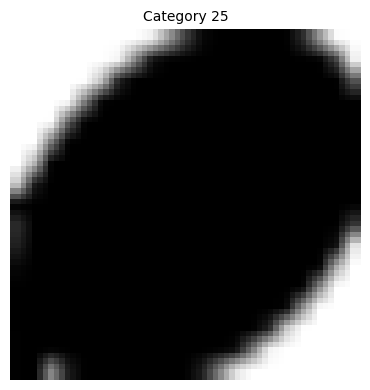

Patch shape: torch.Size([1, 64, 64])


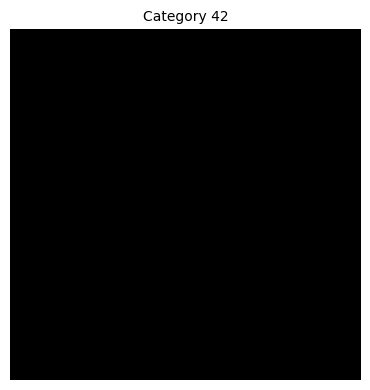

Patch shape: torch.Size([1, 64, 64])


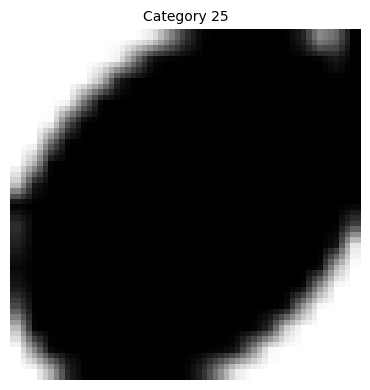

Patch shape: torch.Size([1, 64, 64])


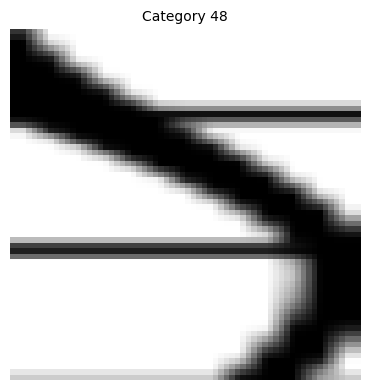

Patch shape: torch.Size([1, 64, 64])


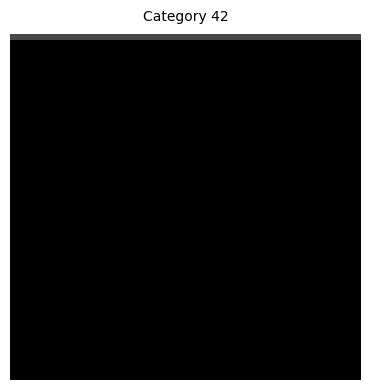

Patch shape: torch.Size([1, 64, 64])


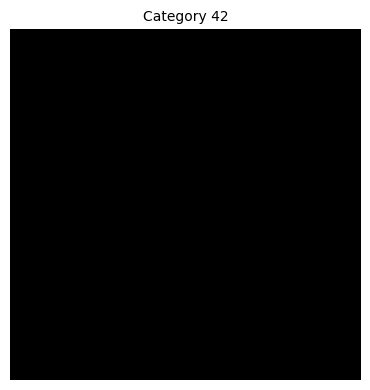

Patch shape: torch.Size([1, 64, 64])


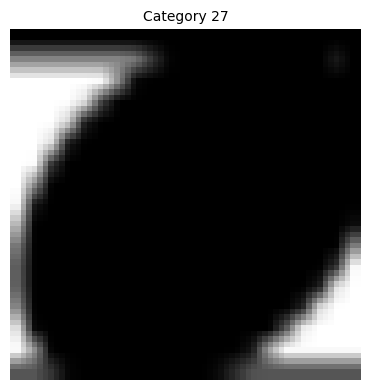

Patch shape: torch.Size([1, 64, 64])


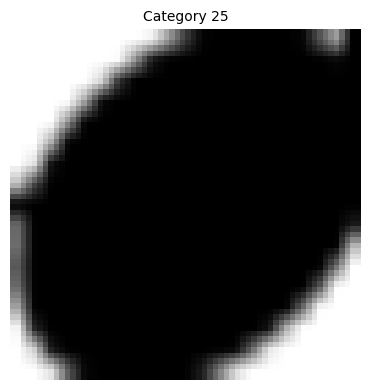

Patch shape: torch.Size([1, 64, 64])


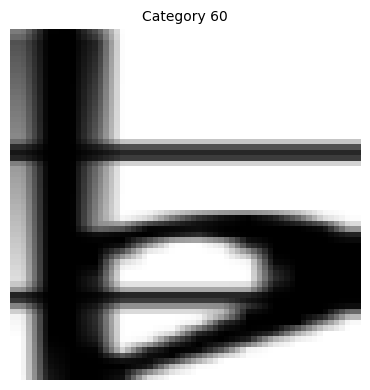

Patch shape: torch.Size([1, 64, 64])


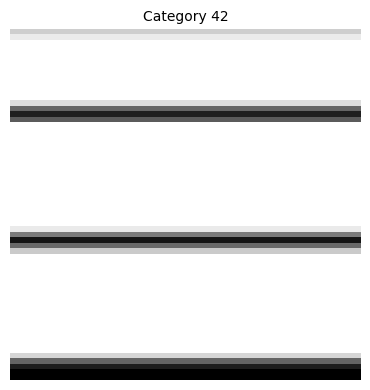

Patch shape: torch.Size([1, 64, 64])


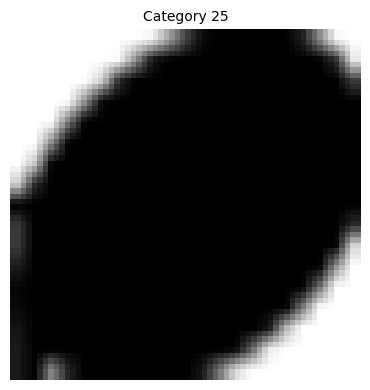

Patch shape: torch.Size([1, 64, 64])


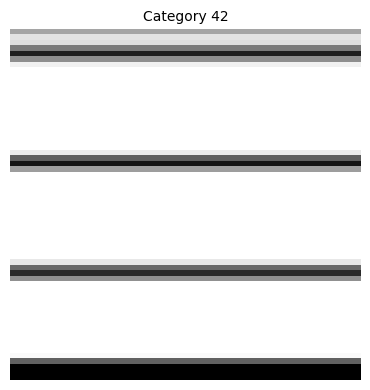

Patch shape: torch.Size([1, 64, 64])


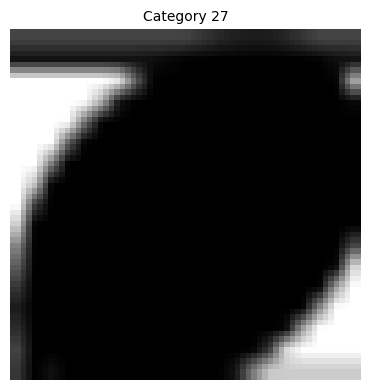

Patch shape: torch.Size([1, 64, 64])


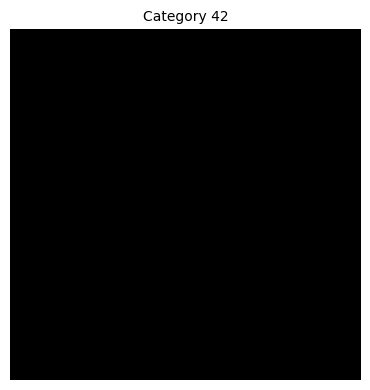

Patch shape: torch.Size([1, 64, 64])


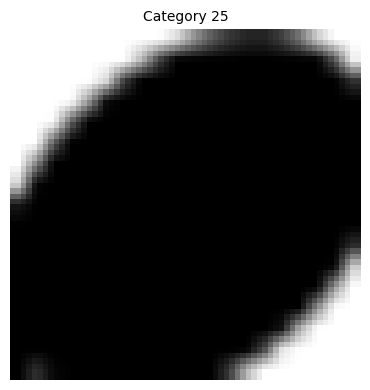

Patch shape: torch.Size([1, 64, 64])


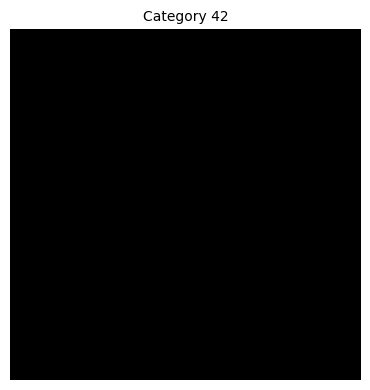

Patch shape: torch.Size([1, 64, 64])


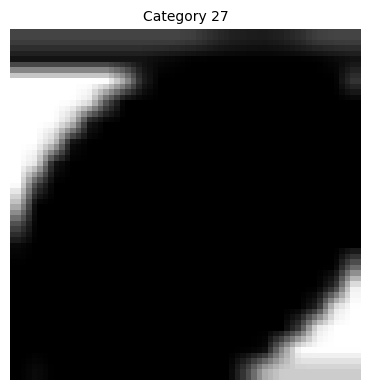

Patch shape: torch.Size([1, 64, 64])


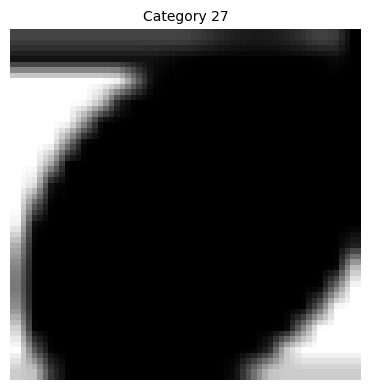

Patch shape: torch.Size([1, 64, 64])


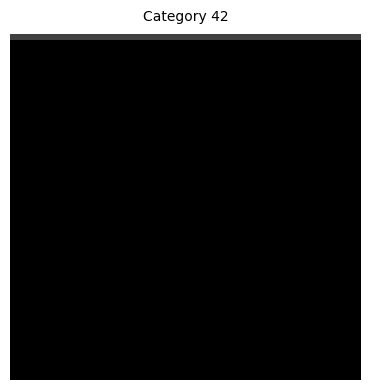

Patch shape: torch.Size([1, 64, 64])


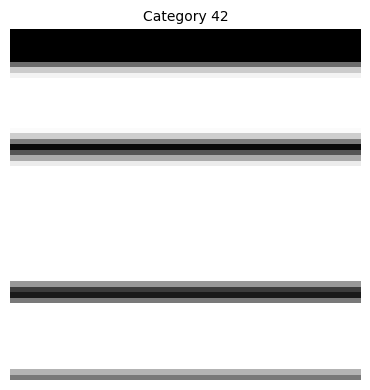

torch.Size([32, 1, 64, 64])
[tensor([42, 25, 25, 85, 68, 68, 68,  7, 68, 68, 68,  6, 68, 68, 68,  6, 85, 85,
        85, 25, 42, 27, 42, 25, 48, 42, 27, 68, 68, 68,  9, 27]), tensor([161, 157, 157, 183, 171, 171, 171, 143, 171, 171, 171, 142, 171, 171,
        171, 142, 183, 183, 183, 157, 161, 157, 161, 157, 163, 161, 157, 171,
        171, 171, 144, 157])]
Patch shape: torch.Size([1, 64, 64])


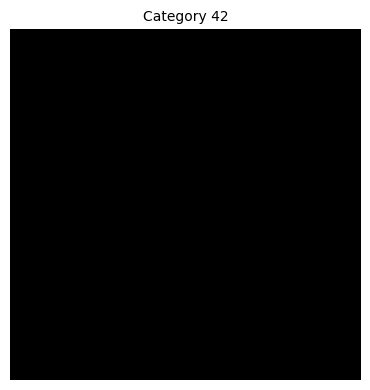

Patch shape: torch.Size([1, 64, 64])


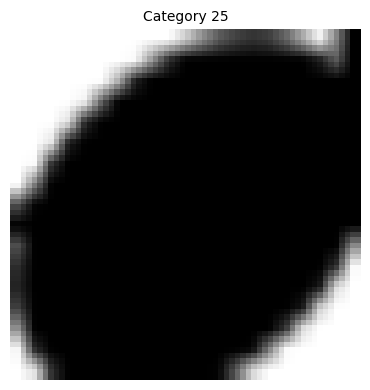

Patch shape: torch.Size([1, 64, 64])


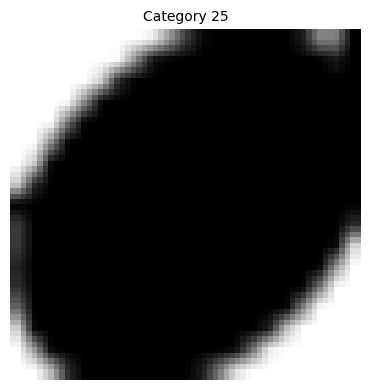

Patch shape: torch.Size([1, 64, 64])


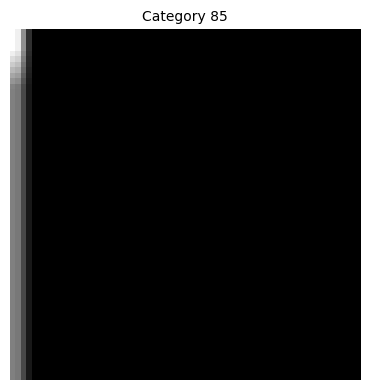

Patch shape: torch.Size([1, 64, 64])


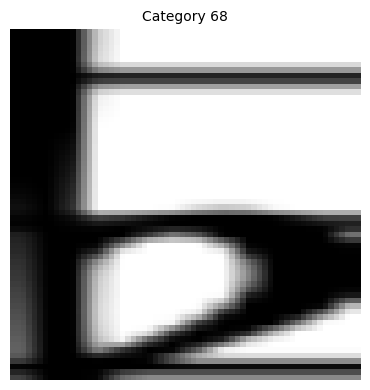

Patch shape: torch.Size([1, 64, 64])


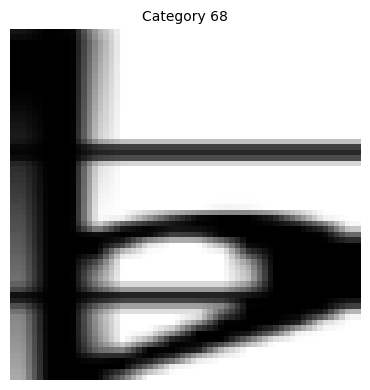

Patch shape: torch.Size([1, 64, 64])


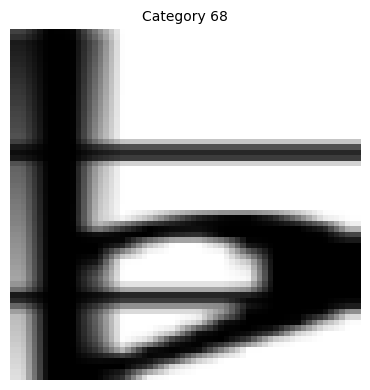

Patch shape: torch.Size([1, 64, 64])


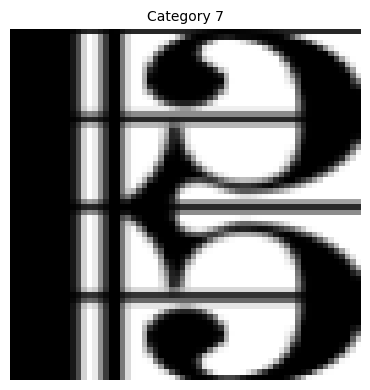

Patch shape: torch.Size([1, 64, 64])


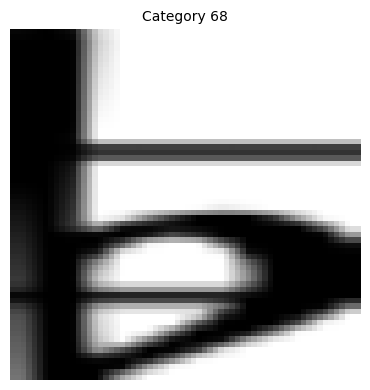

Patch shape: torch.Size([1, 64, 64])


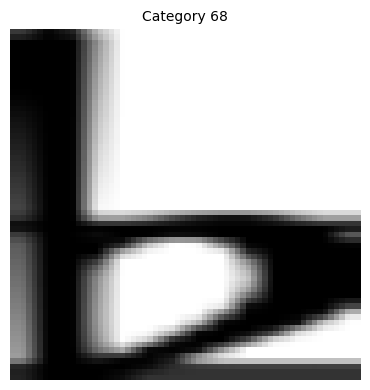

Patch shape: torch.Size([1, 64, 64])


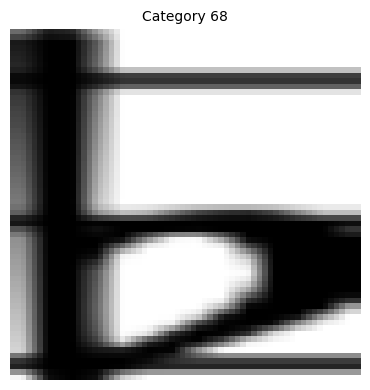

Patch shape: torch.Size([1, 64, 64])


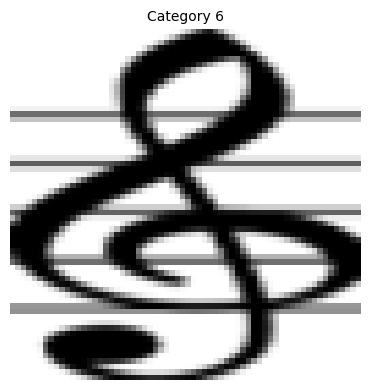

Patch shape: torch.Size([1, 64, 64])


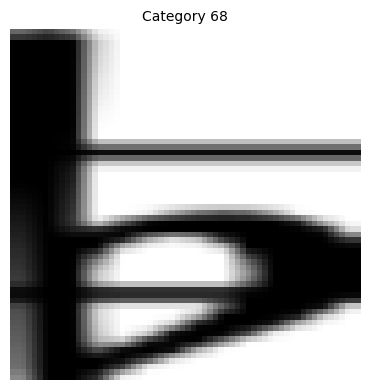

Patch shape: torch.Size([1, 64, 64])


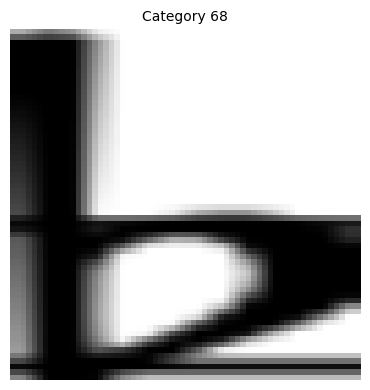

Patch shape: torch.Size([1, 64, 64])


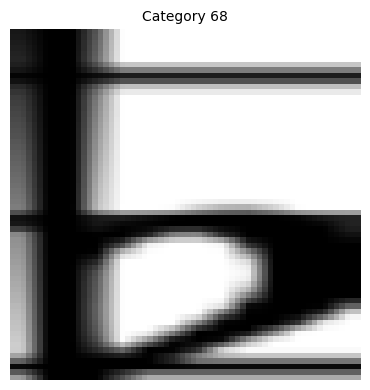

Patch shape: torch.Size([1, 64, 64])


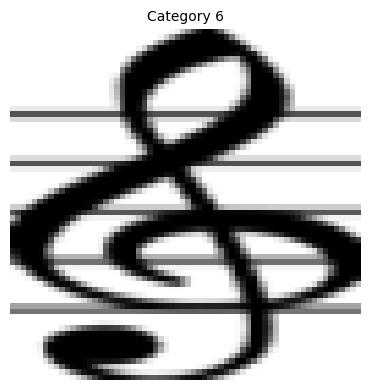

Patch shape: torch.Size([1, 64, 64])


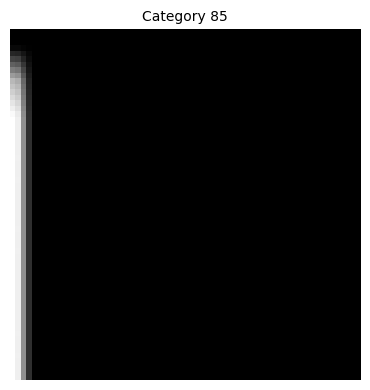

Patch shape: torch.Size([1, 64, 64])


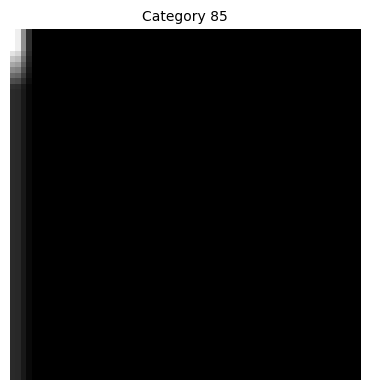

Patch shape: torch.Size([1, 64, 64])


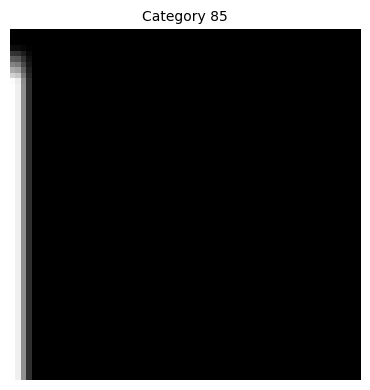

Patch shape: torch.Size([1, 64, 64])


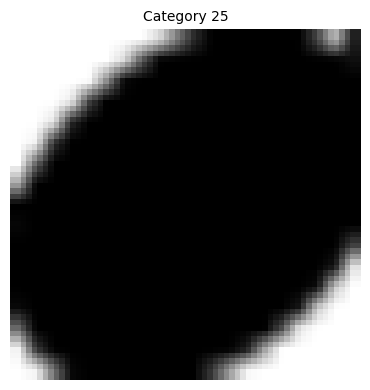

Patch shape: torch.Size([1, 64, 64])


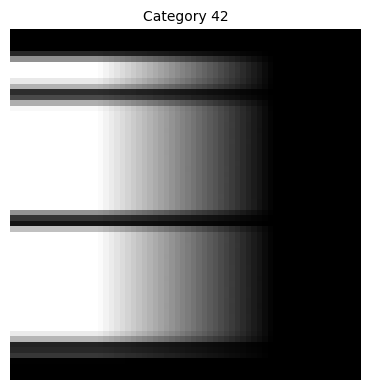

Patch shape: torch.Size([1, 64, 64])


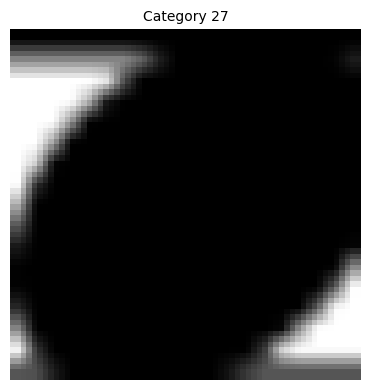

Patch shape: torch.Size([1, 64, 64])


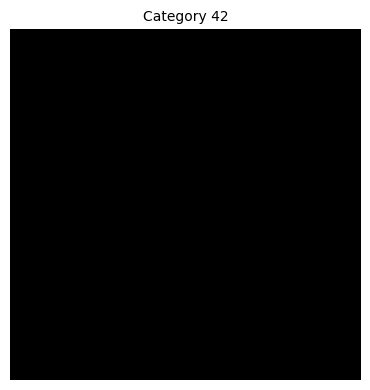

Patch shape: torch.Size([1, 64, 64])


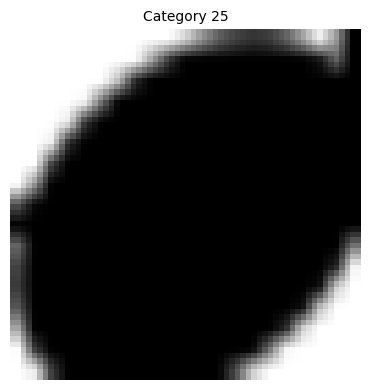

Patch shape: torch.Size([1, 64, 64])


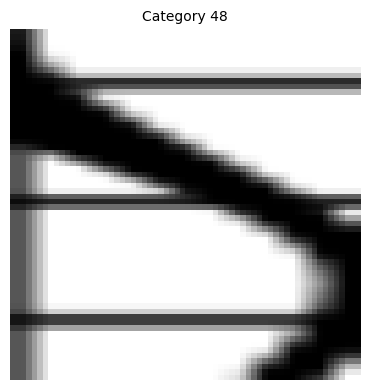

Patch shape: torch.Size([1, 64, 64])


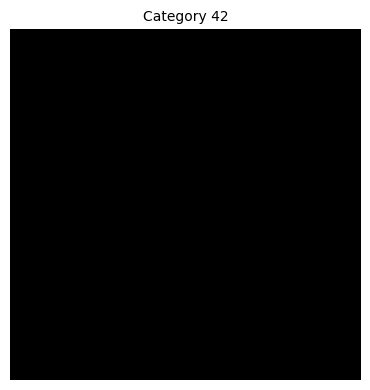

Patch shape: torch.Size([1, 64, 64])


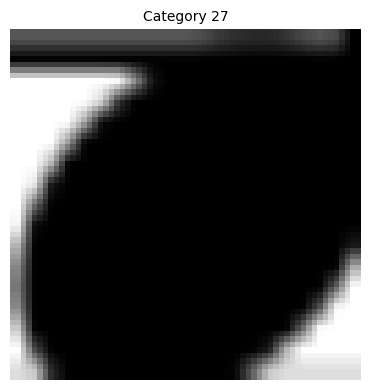

Patch shape: torch.Size([1, 64, 64])


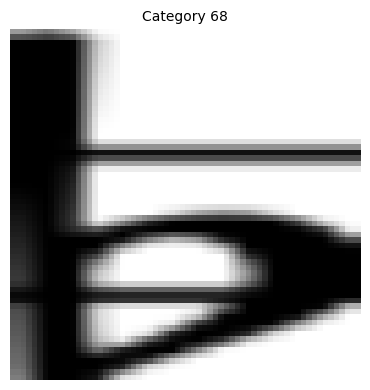

Patch shape: torch.Size([1, 64, 64])


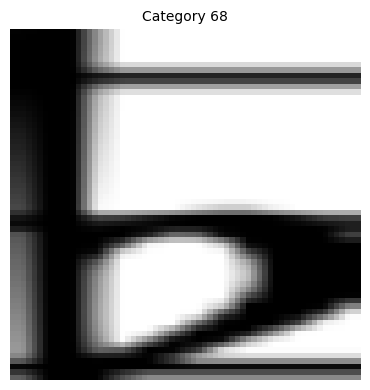

Patch shape: torch.Size([1, 64, 64])


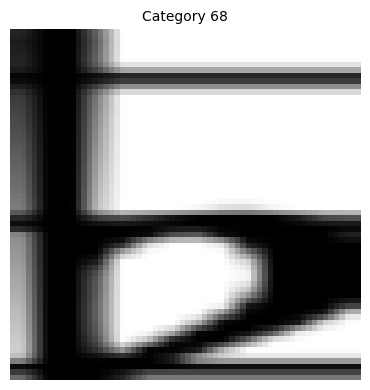

Patch shape: torch.Size([1, 64, 64])


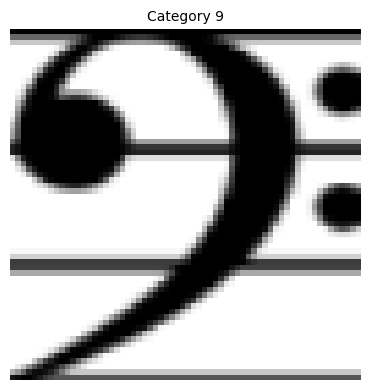

Patch shape: torch.Size([1, 64, 64])


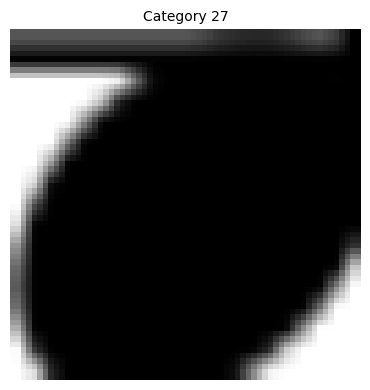

staff line
torch.Size([32, 1, 64, 64])
[tensor([27, 25, 48, 42, 42, 25, 42, 27, 42, 42, 54, 42, 42, 42, 27, 25, 42, 42,
        25, 42, 25, 42, 25, 27, 27, 42, 27,  2,  2,  2,  2,  2]), tensor([157, 157, 163, 161, 161, 157, 161, 157, 161, 161, 167, 161, 161, 161,
        157, 157, 161, 161, 157, 161, 157, 161, 157, 157, 157, 161, 157, 138,
        138, 138, 138, 138])]
Patch shape: torch.Size([1, 64, 64])


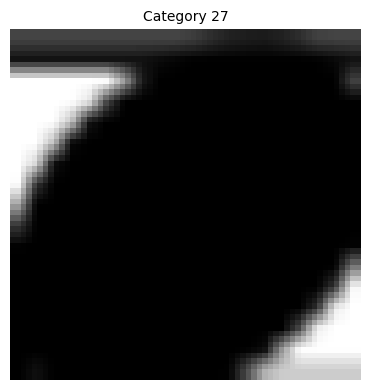

Patch shape: torch.Size([1, 64, 64])


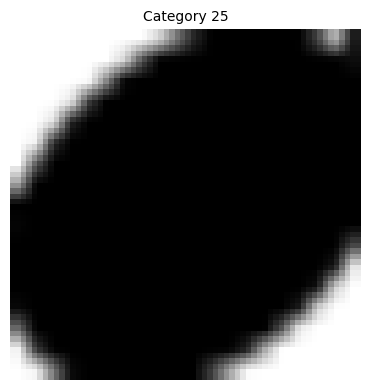

Patch shape: torch.Size([1, 64, 64])


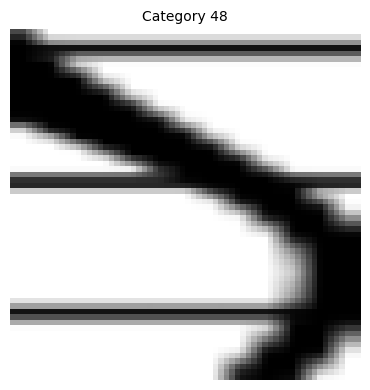

Patch shape: torch.Size([1, 64, 64])


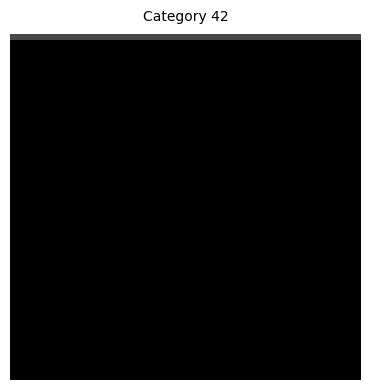

Patch shape: torch.Size([1, 64, 64])


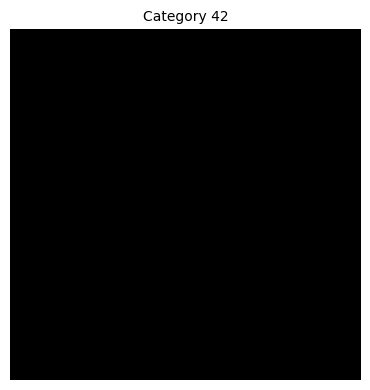

Patch shape: torch.Size([1, 64, 64])


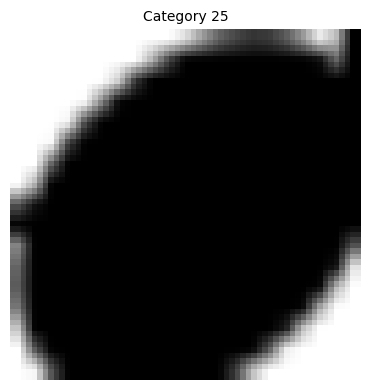

Patch shape: torch.Size([1, 64, 64])


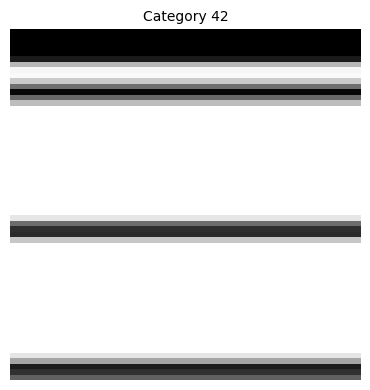

Patch shape: torch.Size([1, 64, 64])


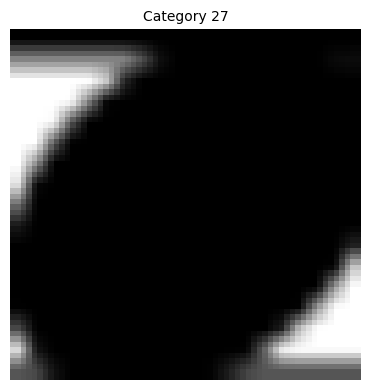

Patch shape: torch.Size([1, 64, 64])


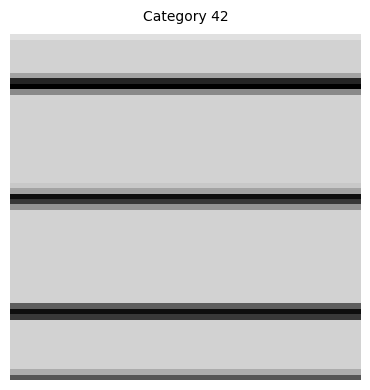

Patch shape: torch.Size([1, 64, 64])


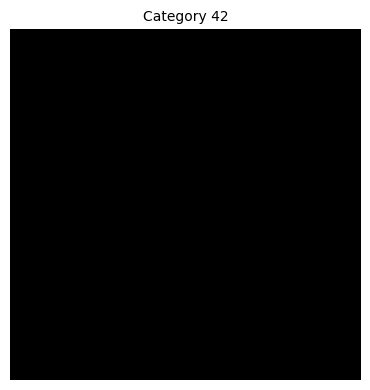

Patch shape: torch.Size([1, 64, 64])


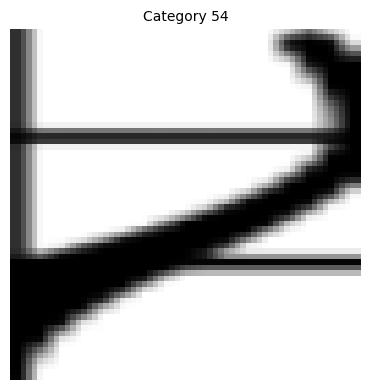

Patch shape: torch.Size([1, 64, 64])


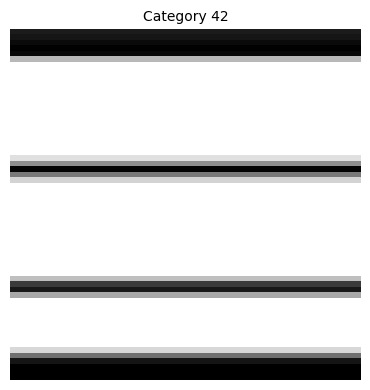

Patch shape: torch.Size([1, 64, 64])


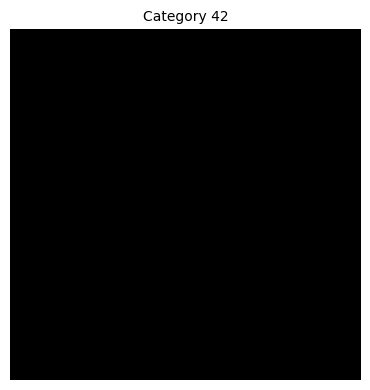

Patch shape: torch.Size([1, 64, 64])


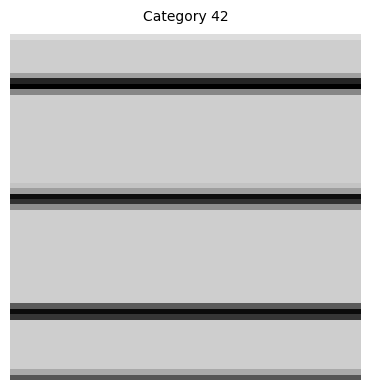

Patch shape: torch.Size([1, 64, 64])


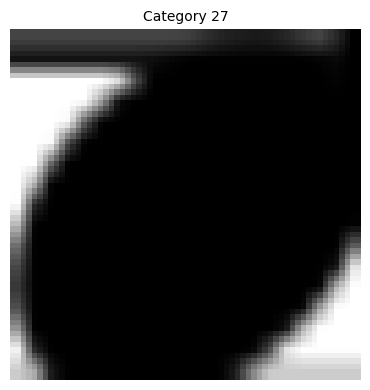

Patch shape: torch.Size([1, 64, 64])


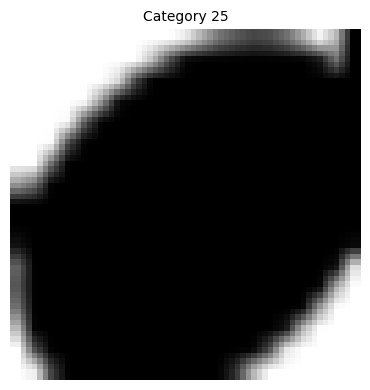

Patch shape: torch.Size([1, 64, 64])


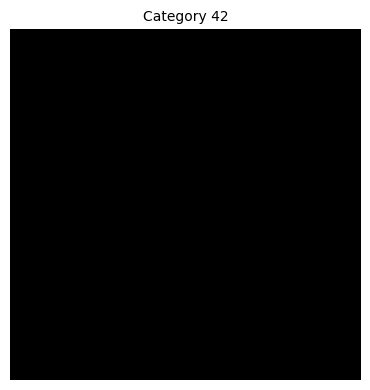

Patch shape: torch.Size([1, 64, 64])


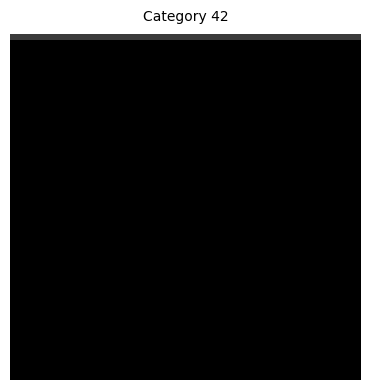

Patch shape: torch.Size([1, 64, 64])


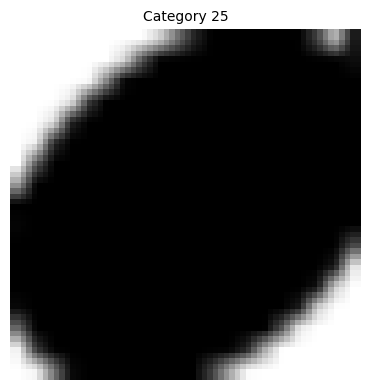

Patch shape: torch.Size([1, 64, 64])


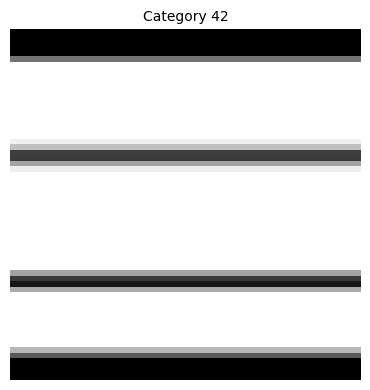

Patch shape: torch.Size([1, 64, 64])


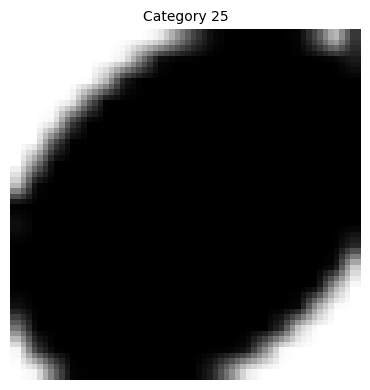

Patch shape: torch.Size([1, 64, 64])


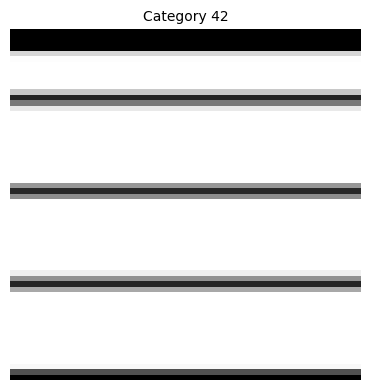

Patch shape: torch.Size([1, 64, 64])


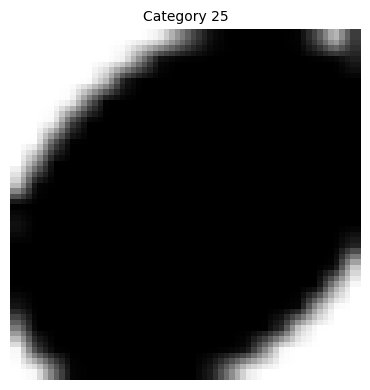

Patch shape: torch.Size([1, 64, 64])


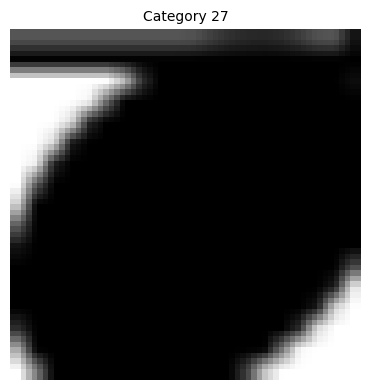

Patch shape: torch.Size([1, 64, 64])


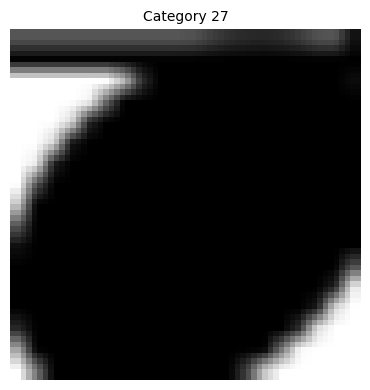

Patch shape: torch.Size([1, 64, 64])


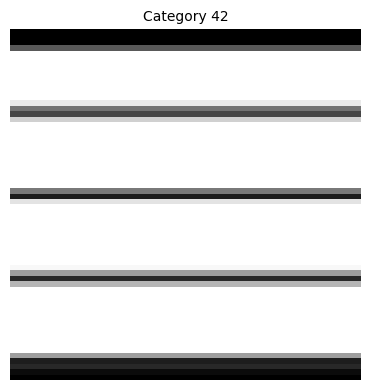

Patch shape: torch.Size([1, 64, 64])


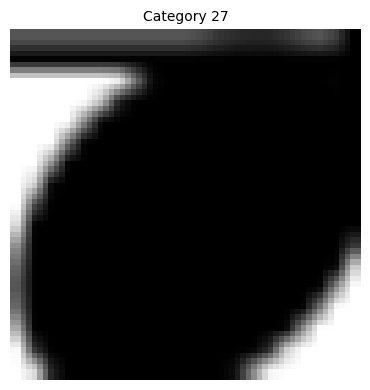

Patch shape: torch.Size([1, 64, 64])


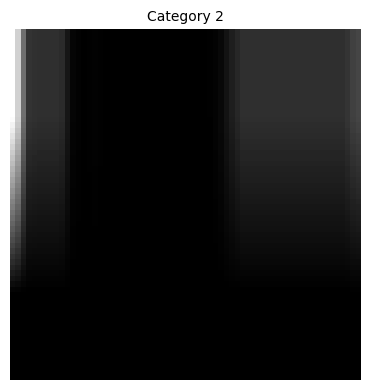

Patch shape: torch.Size([1, 64, 64])


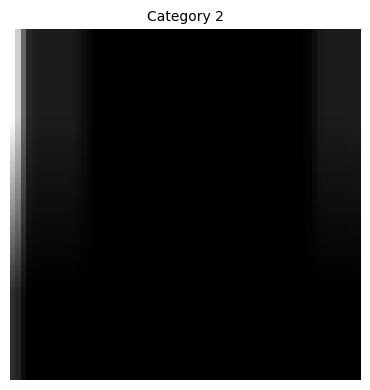

Patch shape: torch.Size([1, 64, 64])


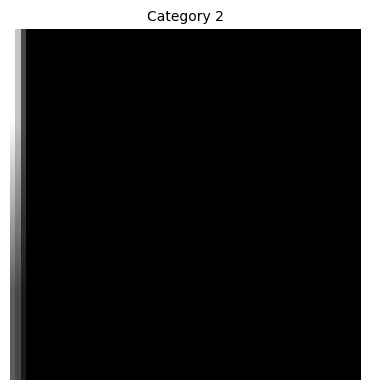

Patch shape: torch.Size([1, 64, 64])


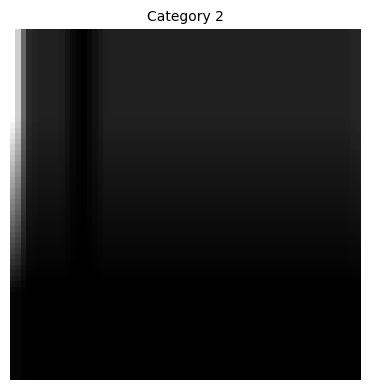

Patch shape: torch.Size([1, 64, 64])


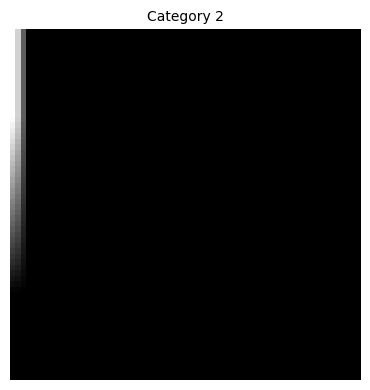

staff line
staff line
staff line
torch.Size([32, 1, 64, 64])
[tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2, 27, 27, 25, 25, 42, 42]), tensor([138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
        138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 157, 157,
        157, 157, 161, 161])]
Patch shape: torch.Size([1, 64, 64])


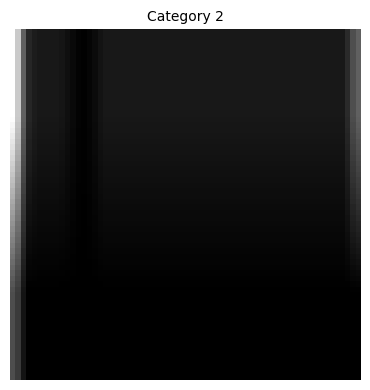

Patch shape: torch.Size([1, 64, 64])


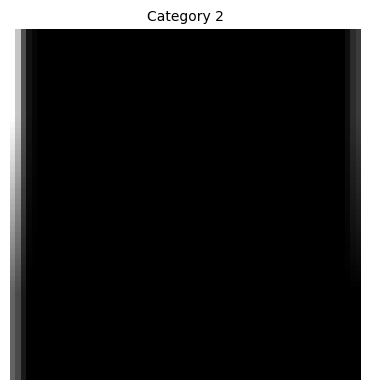

Patch shape: torch.Size([1, 64, 64])


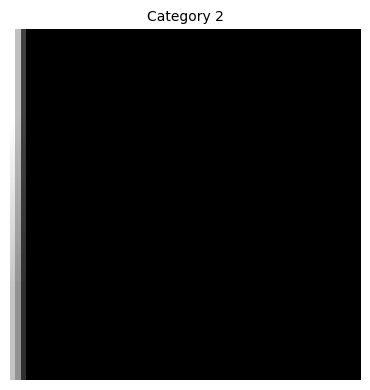

Patch shape: torch.Size([1, 64, 64])


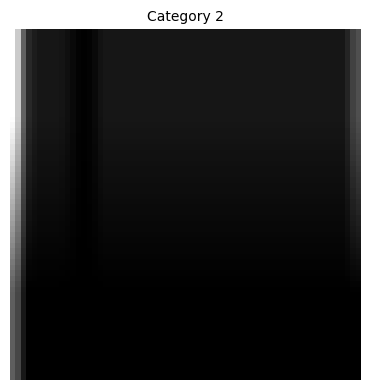

Patch shape: torch.Size([1, 64, 64])


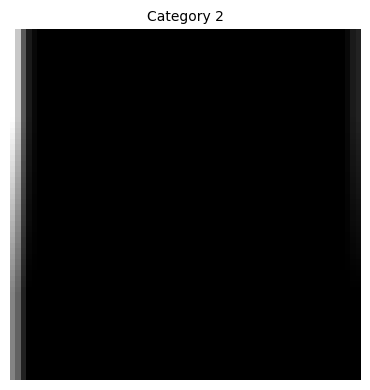

Patch shape: torch.Size([1, 64, 64])


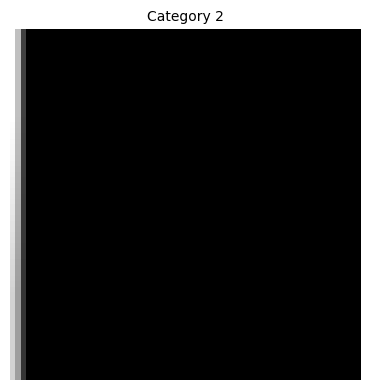

Patch shape: torch.Size([1, 64, 64])


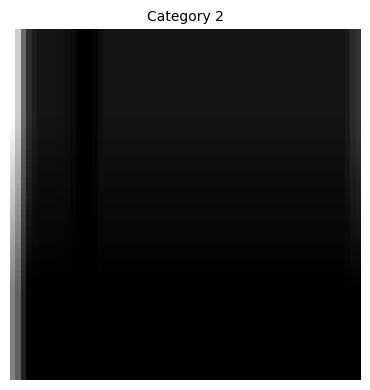

Patch shape: torch.Size([1, 64, 64])


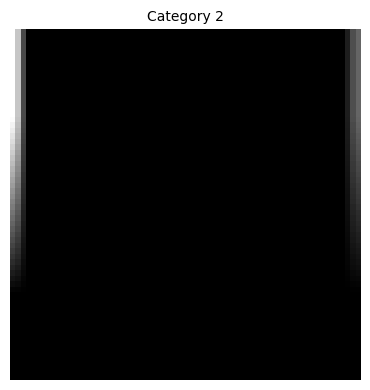

Patch shape: torch.Size([1, 64, 64])


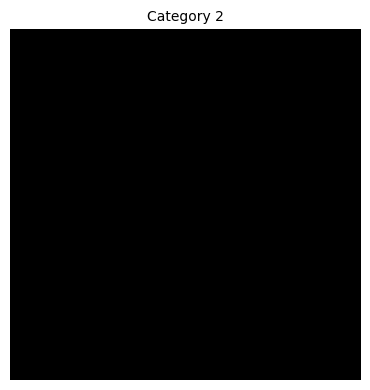

Patch shape: torch.Size([1, 64, 64])


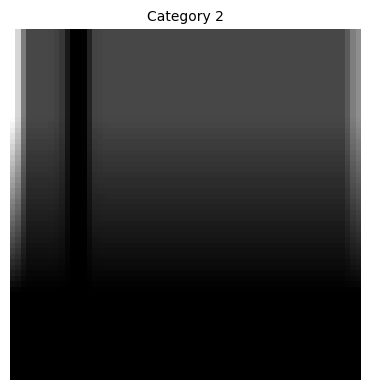

Patch shape: torch.Size([1, 64, 64])


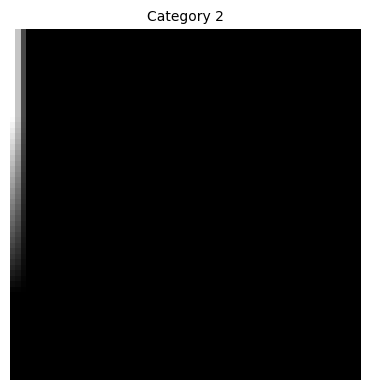

Patch shape: torch.Size([1, 64, 64])


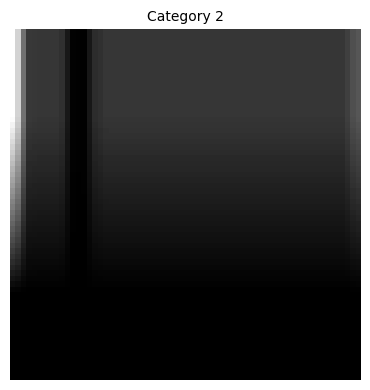

Patch shape: torch.Size([1, 64, 64])


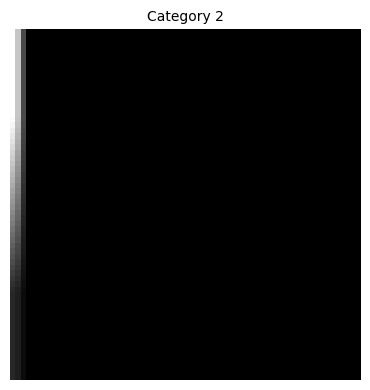

Patch shape: torch.Size([1, 64, 64])


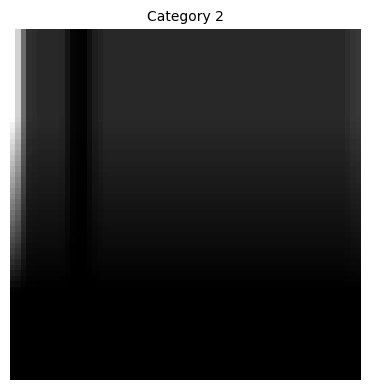

Patch shape: torch.Size([1, 64, 64])


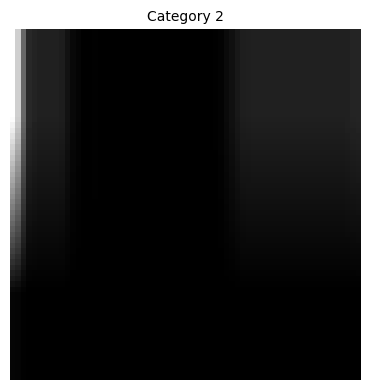

Patch shape: torch.Size([1, 64, 64])


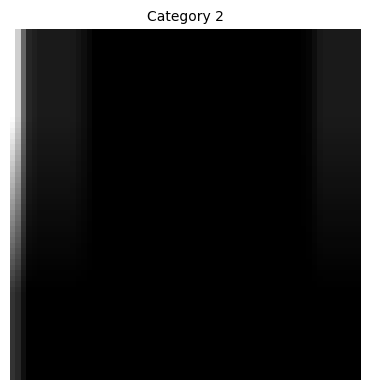

Patch shape: torch.Size([1, 64, 64])


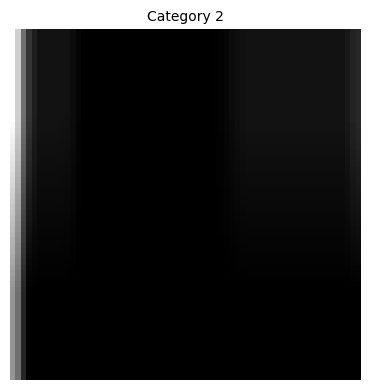

Patch shape: torch.Size([1, 64, 64])


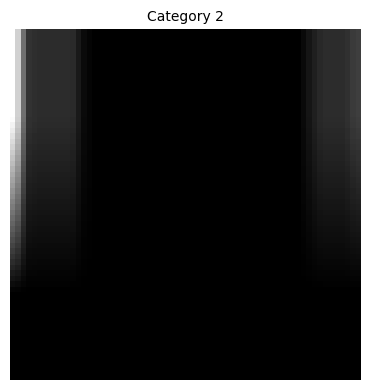

Patch shape: torch.Size([1, 64, 64])


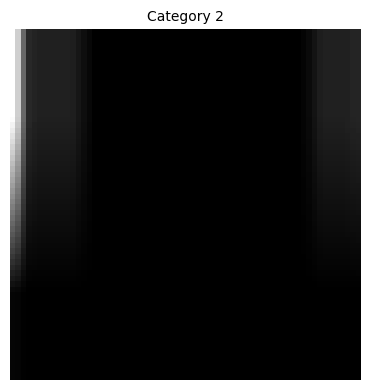

Patch shape: torch.Size([1, 64, 64])


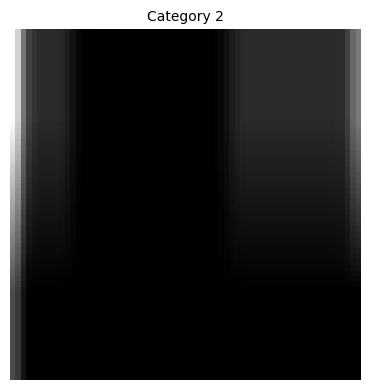

Patch shape: torch.Size([1, 64, 64])


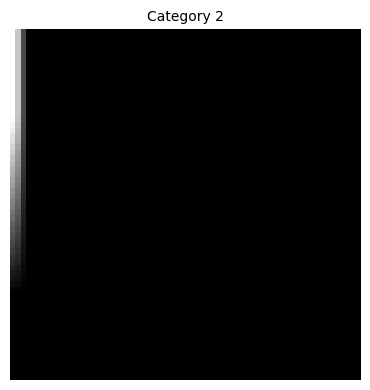

Patch shape: torch.Size([1, 64, 64])


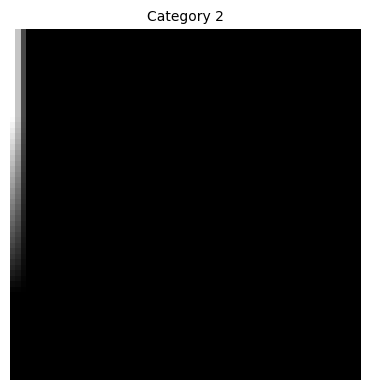

Patch shape: torch.Size([1, 64, 64])


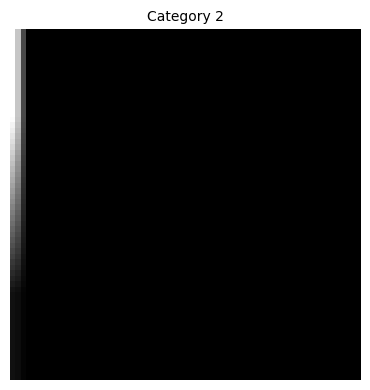

Patch shape: torch.Size([1, 64, 64])


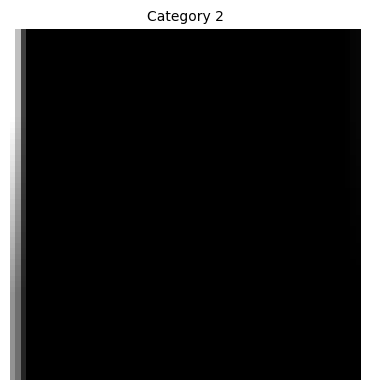

Patch shape: torch.Size([1, 64, 64])


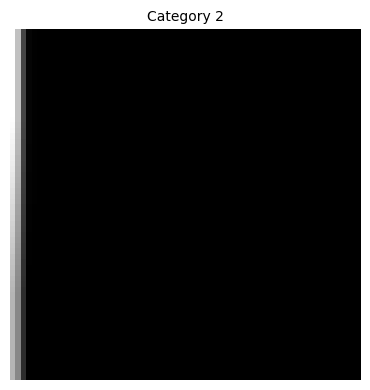

Patch shape: torch.Size([1, 64, 64])


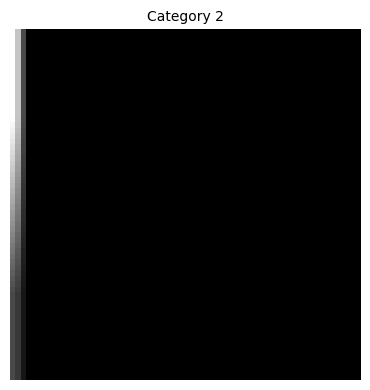

Patch shape: torch.Size([1, 64, 64])


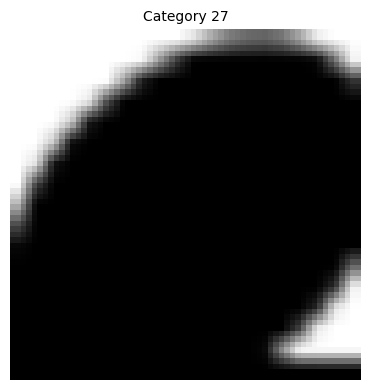

Patch shape: torch.Size([1, 64, 64])


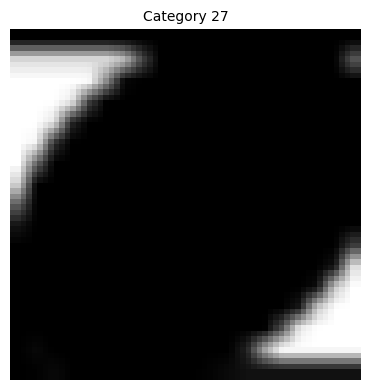

Patch shape: torch.Size([1, 64, 64])


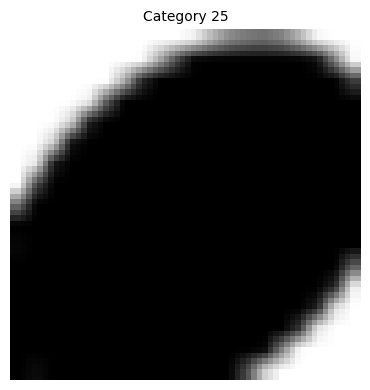

Patch shape: torch.Size([1, 64, 64])


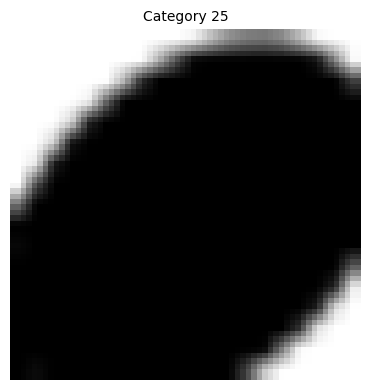

Patch shape: torch.Size([1, 64, 64])


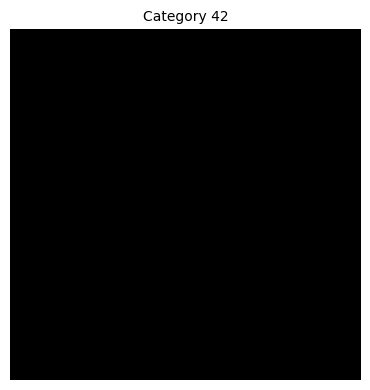

Patch shape: torch.Size([1, 64, 64])


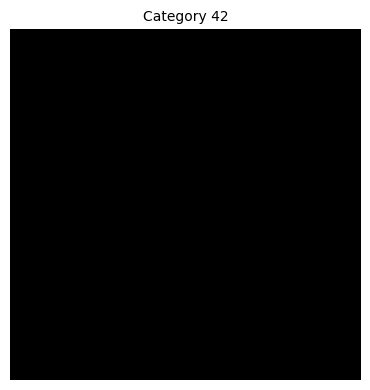

torch.Size([32, 1, 64, 64])
[tensor([ 42,  60,  60,  42,  42,  25,  42,  42,  60,  42,  42,  27,  42,  54,
         42,  48,  42,  54,  25,  27,  27,  27,  42,  54,  42,  54, 122,  25,
         27,  25,  27,   9]), tensor([161, 171, 171, 161, 161, 157, 161, 161, 171, 161, 161, 157, 161, 167,
        161, 163, 161, 167, 157, 157, 157, 157, 161, 167, 161, 167, 201, 157,
        157, 157, 157, 144])]
Patch shape: torch.Size([1, 64, 64])


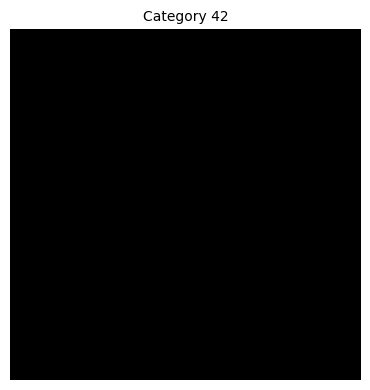

Patch shape: torch.Size([1, 64, 64])


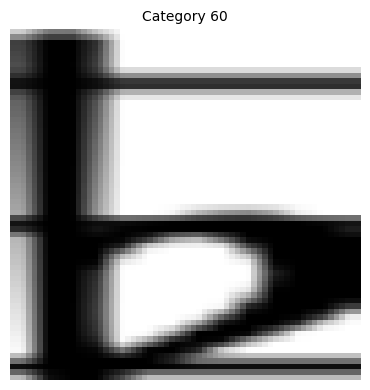

Patch shape: torch.Size([1, 64, 64])


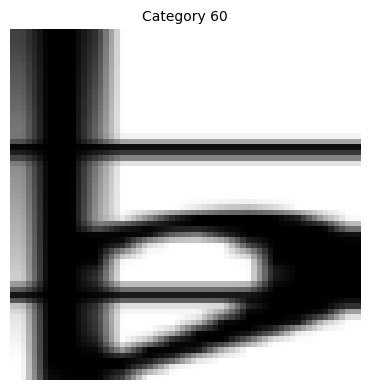

Patch shape: torch.Size([1, 64, 64])


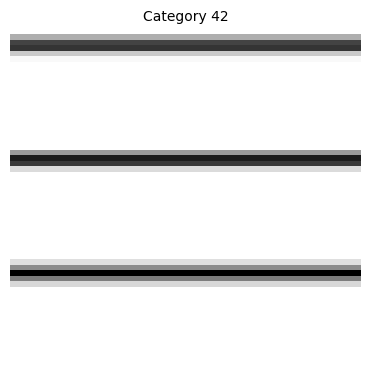

Patch shape: torch.Size([1, 64, 64])


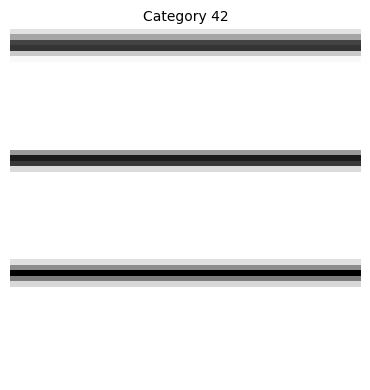

Patch shape: torch.Size([1, 64, 64])


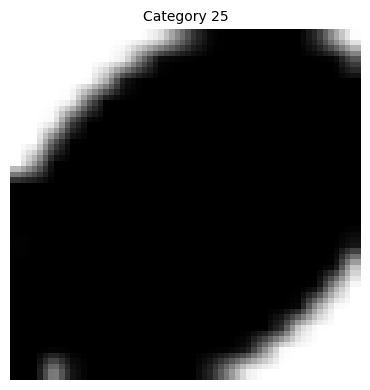

Patch shape: torch.Size([1, 64, 64])


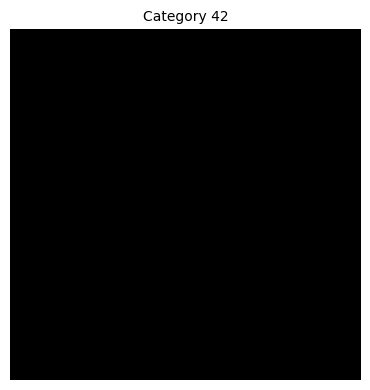

Patch shape: torch.Size([1, 64, 64])


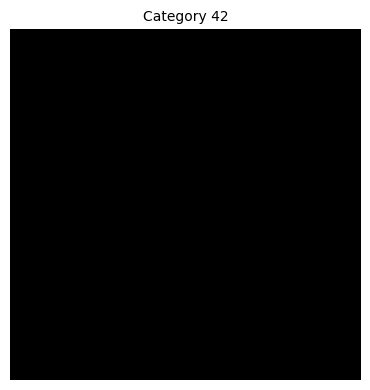

Patch shape: torch.Size([1, 64, 64])


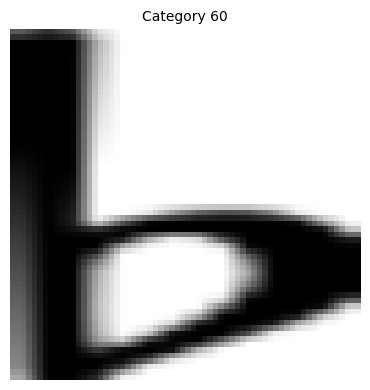

Patch shape: torch.Size([1, 64, 64])


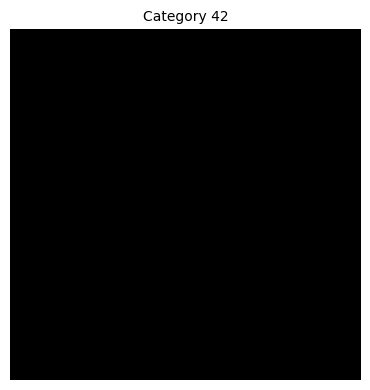

Patch shape: torch.Size([1, 64, 64])


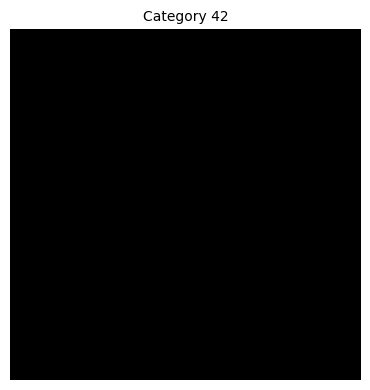

Patch shape: torch.Size([1, 64, 64])


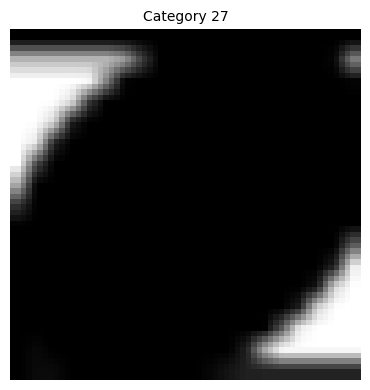

Patch shape: torch.Size([1, 64, 64])


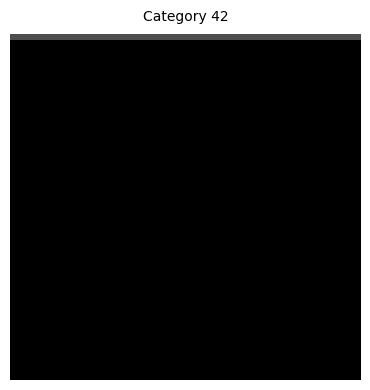

Patch shape: torch.Size([1, 64, 64])


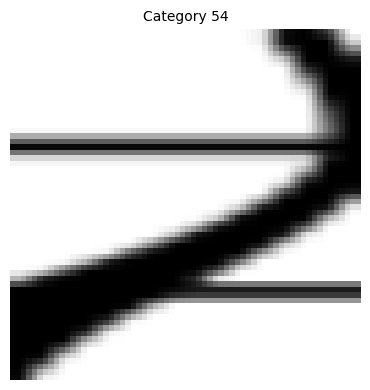

Patch shape: torch.Size([1, 64, 64])


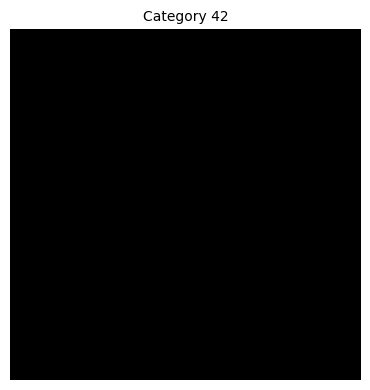

Patch shape: torch.Size([1, 64, 64])


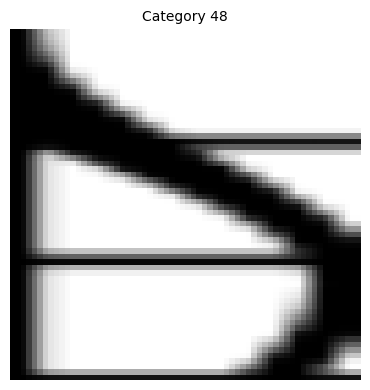

Patch shape: torch.Size([1, 64, 64])


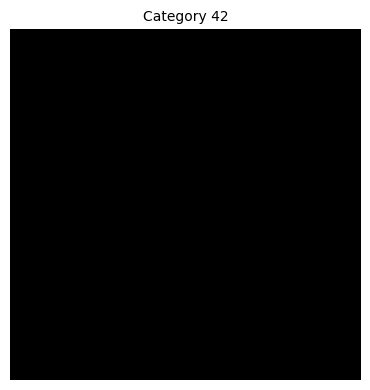

Patch shape: torch.Size([1, 64, 64])


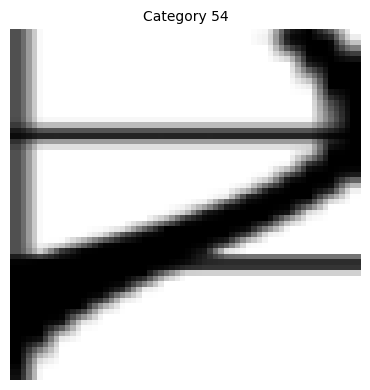

Patch shape: torch.Size([1, 64, 64])


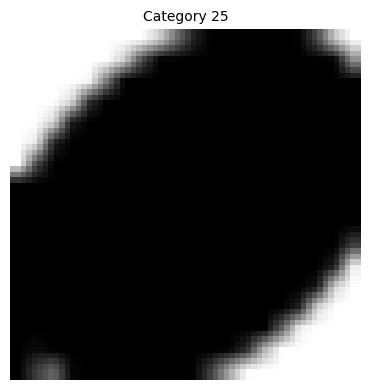

Patch shape: torch.Size([1, 64, 64])


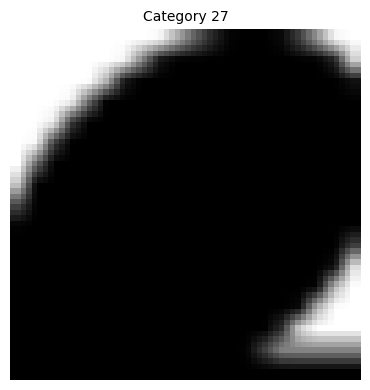

Patch shape: torch.Size([1, 64, 64])


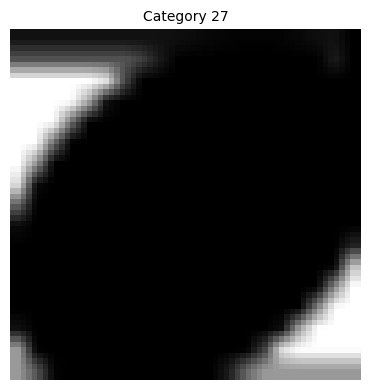

Patch shape: torch.Size([1, 64, 64])


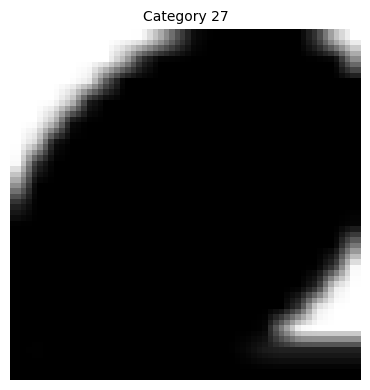

Patch shape: torch.Size([1, 64, 64])


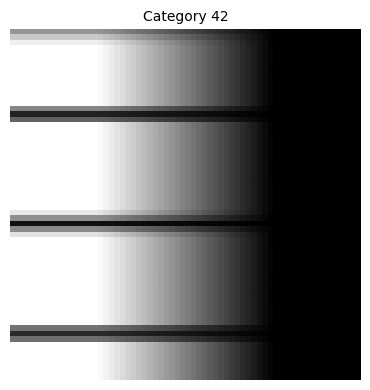

Patch shape: torch.Size([1, 64, 64])


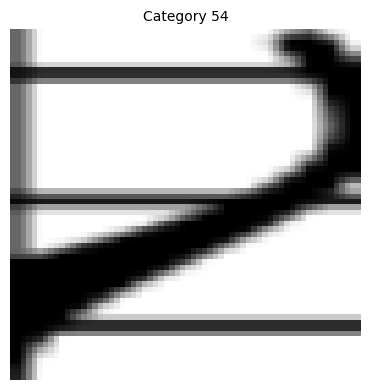

Patch shape: torch.Size([1, 64, 64])


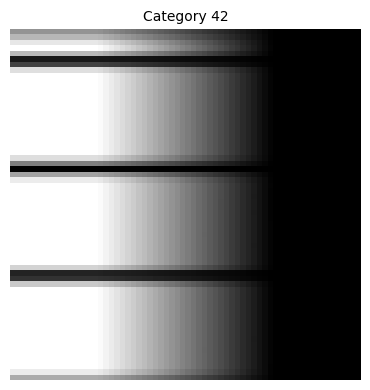

Patch shape: torch.Size([1, 64, 64])


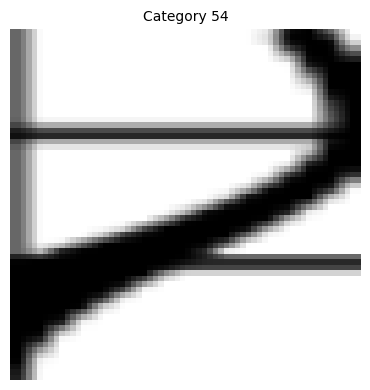

Patch shape: torch.Size([1, 64, 64])


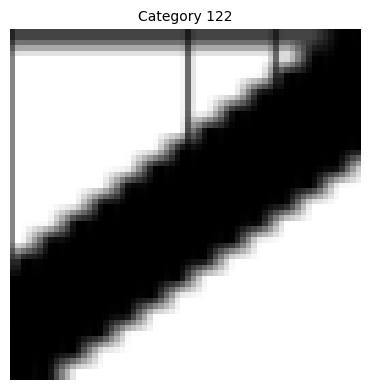

Patch shape: torch.Size([1, 64, 64])


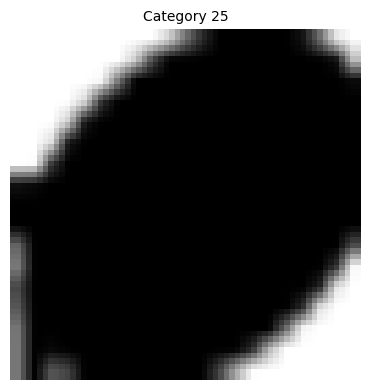

Patch shape: torch.Size([1, 64, 64])


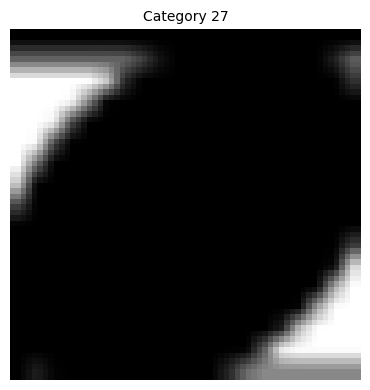

Patch shape: torch.Size([1, 64, 64])


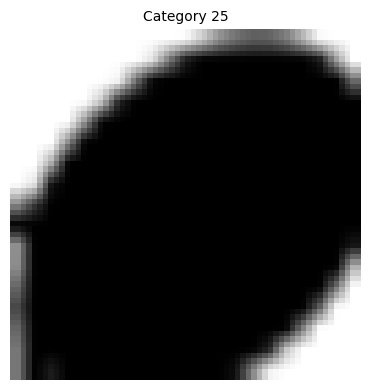

Patch shape: torch.Size([1, 64, 64])


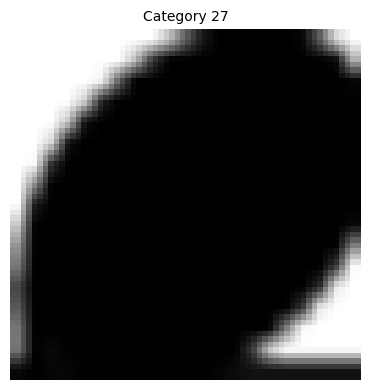

Patch shape: torch.Size([1, 64, 64])


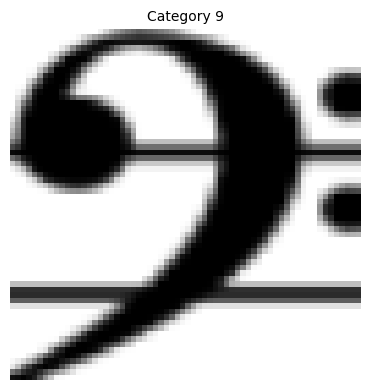

torch.Size([32, 1, 64, 64])
[tensor([42, 42, 54, 42, 25, 42, 27, 25, 27, 27, 42, 27, 27, 25, 25, 42, 42, 42,
        42, 42, 27, 25, 25, 25,  8, 42, 54, 42, 54, 42, 42, 27]), tensor([161, 161, 167, 161, 157, 161, 157, 157, 157, 157, 161, 157, 157, 157,
        157, 161, 161, 161, 161, 161, 157, 157, 157, 157, 143, 161, 167, 161,
        167, 161, 161, 157])]


In [35]:
for n, (batch_patches, batch_cats) in  enumerate(dataloader):
    print(batch_patches.shape)
    print(batch_cats)
    if(n >= 10):
        
        break
    
    for i in range(len(batch_cats[0])):
        plot_img(batch_patches[i], batch_cats[0][i])

In [36]:
filepath = r"C:\Users\alexh\Desktop\ComputerVision\Hausarbeit\deepscores_v2_dense\ds2_dense\deepscores_train.json"
basePath = r"C:\Users\alexh\Desktop\ComputerVision\Hausarbeit\deepscores_v2_dense\ds2_dense\images\\" 
o = OBBAnns(filepath)
o.load_annotations()

loading ann_info...
done! t=7.76s


In [59]:
df.to_json("categories_sorted.json", orient="index", indent=2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

class MyLeNet(nn.Module):
    def __init__(self):
        super(MyLeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=8, kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels=16, kernel_size = 5, stride = 1, padding = 0) 
        self.linear1 = nn.Linear(in_features = 2704, out_features = 120)
        self.linear2 = nn.Linear(in_features = 120, out_features = 84)
        self.linear3 = nn.Linear(in_features = 84, out_features = 136)

    def forward(self, x):  
        #32x64x64x1
        x = self.relu(self.conv1(x)) 
        #32x60x60x8
        x = self.pool(x) 
        #32x30x30x8
        x = self.relu(self.conv2(x)) 
        #32x26x26x16
        x = self.pool(x)
        #32x13x13x16
        x = self.relu(self.linear1(x.reshape(x.shape[0], -1)))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)

        return x